<a href="https://colab.research.google.com/github/deepavarshini09/EEG_ALS_Detection/blob/main/EEG_ALS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EEG - ALS DETECTION - MACHINE LEARNING PROJECT

## SECTION 0 - INTRODUCTION

In [6]:
# 🧭 SECTION 0 — OVERVIEW & SETUP
# =========================================================

# 📘 Project: EEG-based ALS Detection using EEGET-ALS Dataset
# 🎯 Objective: Build an ML + DL model to classify ALS vs Healthy EEG
# 🧩 Workflow Sections:
# 0. Setup & Overview
# 1. Load EEGET-ALS Dataset
# 2. Preprocess EEG
# 3. Feature Extraction
# 4. Model Training (Classical ML)
# 5. Deep Learning (EEGNet / CNN)
# 6. Evaluation & Explainability
# 7. Gradio GUI
# 8. Summary & References

In [7]:
# Mount Google Drive for data storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing the necessary packages
!pip install mne scipy numpy pandas scikit-learn xgboost matplotlib seaborn shap gradio torch torchvision torchaudio --quiet

In [ ]:
# Importing standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# REQUIRED EEG and ML Libraries
import mne
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim

import shap
import gradio as gr

In [ ]:
# Path configuration
BASE_DIR = "/content/drive/MyDrive/EEG_Project"

# Subdirectories for outputs (these will be created automatically)
DATASET_DIR = os.path.join(BASE_DIR, "EEGET-ALS Dataset")
PREPROC_DIR = os.path.join(BASE_DIR, "preprocessed")
FEATURE_DIR = os.path.join(BASE_DIR, "features")
MODEL_DIR = os.path.join(BASE_DIR, "models")
RESULT_DIR = os.path.join(BASE_DIR, "results")

# Create directories if they don't exist
for path in [PREPROC_DIR, FEATURE_DIR, MODEL_DIR, RESULT_DIR]:
    os.makedirs(path, exist_ok=True)

print("✅ Setup complete! Using existing dataset folder:")
print("📂 Dataset path:", DATASET_DIR)

✅ Setup complete! Using existing dataset folder:
📂 Dataset path: /content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset


## SECTION 1 - LOAD AND EXPLORE THE EEG-ALS DATASET

In [ ]:
import os
import mne
from glob import glob

print("📂 Dataset base directory:", DATASET_DIR)

📂 Dataset base directory: /content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset


In [ ]:
import os

edf_files = []
for root, _, files in os.walk(DATASET_DIR):
    for f in files:
        if f.endswith(".edf"):
            edf_files.append(os.path.join(root, f))

print("Found", len(edf_files), "files.")
np.save(os.path.join(BASE_DIR, "edf_file_list.npy"), np.array(edf_files))

Found 1991 files.


In [ ]:
import numpy as np

edf_files = np.load(os.path.join(BASE_DIR, "edf_file_list.npy"), allow_pickle=True)
print(f"✅ Loaded {len(edf_files)} EEG file paths from saved list.")
print("Example file path:", edf_files[0])


✅ Loaded 1991 EEG file paths from saved list.
Example file path: /content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset/id96/time1/scenario8/EEG.edf


In [ ]:
# =========================================================
# 🧩 SECTION 1.2 — LOAD AND VISUALIZE A SAMPLE EEG RECORDING
# =========================================================

import mne
import numpy as np
import matplotlib.pyplot as plt

# Load the cached EDF file list (instant)
edf_files = np.load(os.path.join(BASE_DIR, "edf_file_list.npy"), allow_pickle=True)
print(f"✅ Loaded {len(edf_files)} EEG file paths.")

✅ Loaded 1991 EEG file paths.


In [ ]:
# 1️⃣  Pick one EEG file to inspect (you can change index)
# ---------------------------------------------------------
sample_index = 0   # try changing this to view another file
sample_file = edf_files[sample_index]
print(f"\n📂 Loading EEG file #{sample_index+1}:\n{sample_file}")


📂 Loading EEG file #1:
/content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset/id96/time1/scenario8/EEG.edf


In [ ]:
# 2️⃣  Load EEG data using MNE
# ---------------------------------------------------------
raw = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)

print("\n🧠 EEG File Info:")
print(f" - Sampling frequency: {raw.info['sfreq']} Hz")
print(f" - Number of channels: {len(raw.ch_names)}")
print(f" - Duration: {raw.n_times / raw.info['sfreq']:.2f} seconds")
print(f" - Channel names: {raw.ch_names[:10]}{'...' if len(raw.ch_names) > 10 else ''}")


🧠 EEG File Info:
 - Sampling frequency: 128.0 Hz
 - Number of channels: 32
 - Duration: 138.00 seconds
 - Channel names: ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7']...


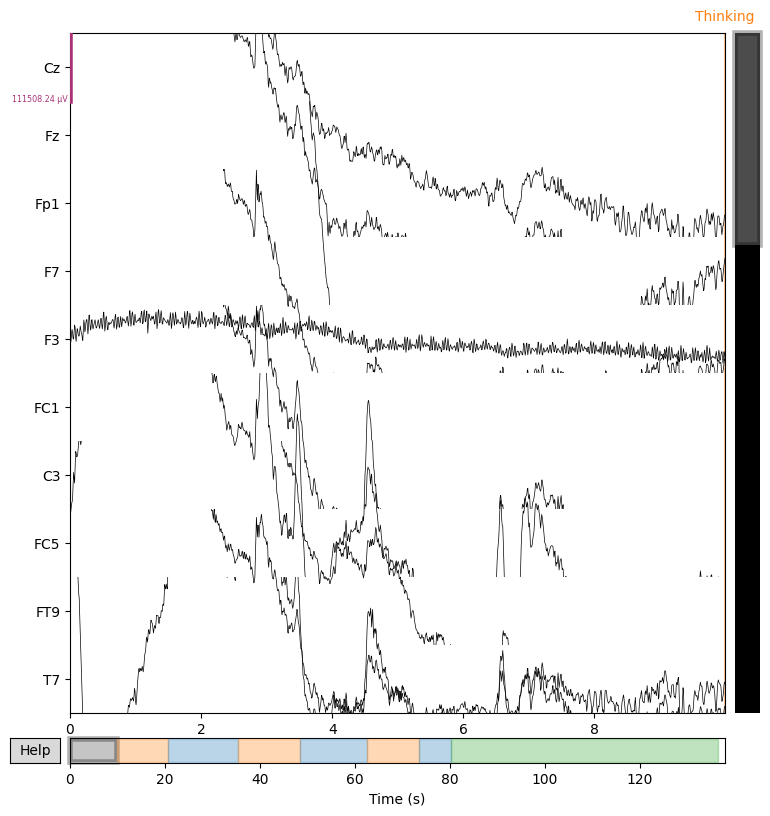

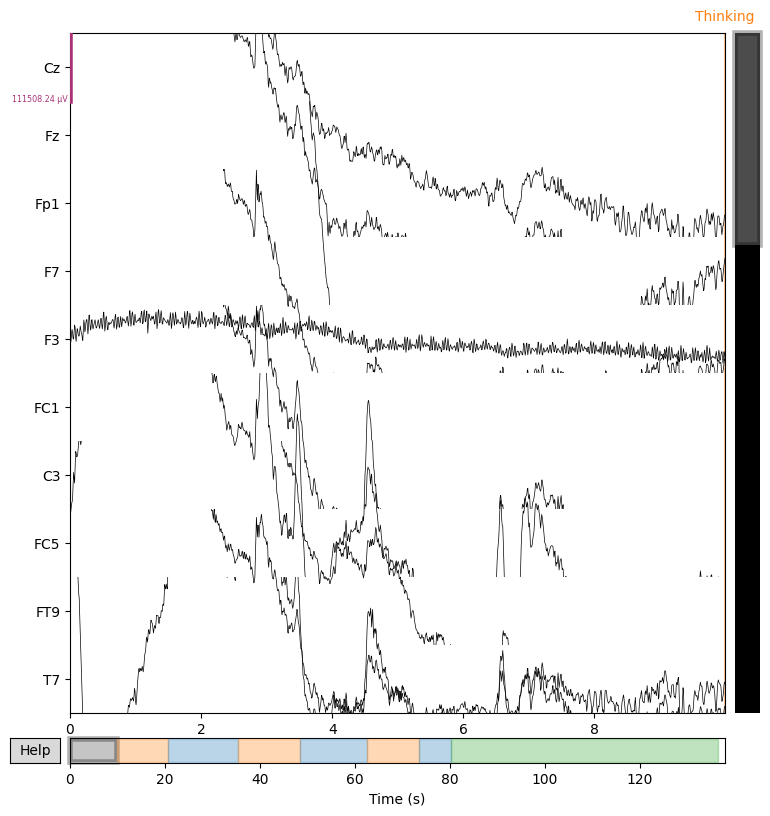

In [ ]:
# 3️⃣  Visualize EEG
# ---------------------------------------------------------
# Plot first 10 seconds of 10 channels
start, duration = 0, 10  # seconds
raw.plot(start=start, duration=duration, n_channels=10, scalings='auto',
          title=f"EEG Segment Preview — {os.path.basename(sample_file)}")

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


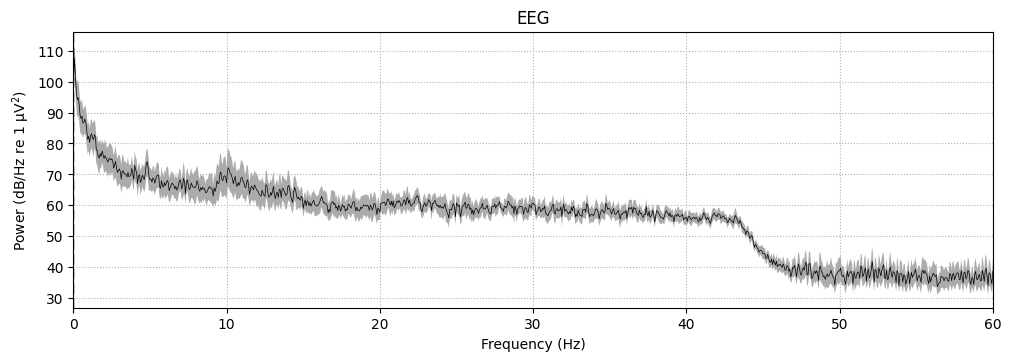

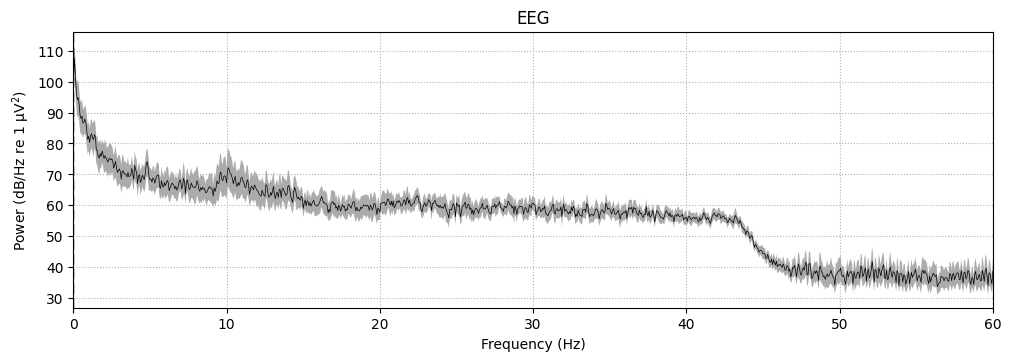

In [ ]:
# 4️⃣  Plot power spectral density (frequency content)
# ---------------------------------------------------------
raw.plot_psd(fmax=60, average=True)

In [ ]:
# 5️⃣  Quick data shape check
# ---------------------------------------------------------
data, times = raw.get_data(return_times=True)
print(f"\n📊 Data shape: {data.shape} (channels × time points)")
print(f"🕒 Total recording time: {times[-1]:.2f} seconds")

print("\n✅ Section 1.2 complete — EEG file successfully loaded and visualized.")


📊 Data shape: (32, 17664) (channels × time points)
🕒 Total recording time: 137.99 seconds

✅ Section 1.2 complete — EEG file successfully loaded and visualized.


## SECTION 2 - EEG PRE-PROCESSING

In [ ]:
# =========================================================
# 🧩 SECTION 2 — EEG PREPROCESSING PIPELINE (FINAL)
# =========================================================
import os
import numpy as np
import mne
from tqdm import tqdm

# ----------------------------
# ⚙️ CONFIGURATION
# ----------------------------
l_freq = 1.0          # Low-cut for bandpass
h_freq = 40.0         # High-cut for bandpass
notch_freqs = [50, 100]
resample_sfreq = 128  # Hz, keep None if not needed
ica_n_components = 15
ica_random_state = 42
do_ica = True
run_batch = True       # Toggle batch mode

# ----------------------------
# 🧰 HELPER FUNCTIONS
# ----------------------------

def mark_and_interpolate_bads(raw):
    """Detect and interpolate bad EEG channels."""
    raw_copy = raw.copy()
    raw_copy.info['bads'] = []  # clear previous bads
    picks = mne.pick_types(raw_copy.info, eeg=True)
    data = raw_copy.get_data(picks)
    channel_std = np.std(data, axis=1)
    threshold = 3 * np.median(channel_std)
    bads = [raw_copy.ch_names[i] for i, s in enumerate(channel_std) if s > threshold]
    if bads:
        raw_copy.info['bads'] = bads
        raw_copy.interpolate_bads(reset_bads=True)
    return bads


def safe_zscore(x):
    """Z-score normalization that supports both 1D and 2D EEG data."""
    if x.ndim == 1:
        return (x - np.mean(x)) / (np.std(x) + 1e-12)
    elif x.ndim == 2:
        return (x - np.mean(x, axis=1, keepdims=True)) / (np.std(x, axis=1, keepdims=True) + 1e-12)
    else:
        raise ValueError(f"Unexpected data shape: {x.shape}")


def save_preproc(raw, fpath):
    """Save preprocessed EEG to .fif"""
    base_name = os.path.basename(fpath).replace(".edf", "_preproc.fif")
    outp = os.path.join(PREPROC_DIR, base_name)
    raw.save(outp, overwrite=True, verbose=False)
    return outp

In [ ]:
# =========================================================
# 🚀 SMOKE TEST (Run on one file before batch)
# =========================================================
print("\n--- SMOKE TEST: Loading 1 EDF file ---")

sample_file = edf_files[0]
try:
    raw = mne.io.read_raw_edf(sample_file, preload=True, verbose=False)
    print(f"✅ Loaded: {sample_file}")
    print(f"Channels: {len(raw.ch_names)} | SFreq: {raw.info['sfreq']} Hz")

    # Pick EEG only
    eeg_chs = mne.pick_types(raw.info, eeg=True)
    if len(eeg_chs) == 0:
        raise ValueError("No EEG channels found in sample file.")
    raw.pick(eeg_chs)

    # Filters
    raw.filter(l_freq, h_freq, fir_design='firwin', verbose=False)
    try:
        raw.notch_filter(freqs=[f for f in notch_freqs if f < raw.info['sfreq'] / 2], verbose=False)
    except Exception as e:
        print(f"⚠️ Skipped notch filter: {e}")

    # Reference & DC offset
    raw.set_eeg_reference('average', projection=True, verbose=False)
    raw.apply_function(lambda x: x - np.mean(x, axis=-1, keepdims=True))

    # Bad channel handling
    bads = mark_and_interpolate_bads(raw)
    if bads:
        print("Interpolated bad channels:", bads)

    # ICA (optional)
    if do_ica:
        from mne.preprocessing import ICA
        ica = ICA(n_components=min(ica_n_components, len(raw.ch_names)-1),
                  random_state=ica_random_state, max_iter='auto')
        ica.fit(raw)
        try:
            eog_inds, scores = ica.find_bads_eog(raw)
            ica.exclude = eog_inds
            raw = ica.apply(raw)
        except Exception:
            pass

    # Normalize
    raw.apply_function(safe_zscore)

    # Save
    outp = save_preproc(raw, sample_file)
    print(f"💾 Saved preprocessed sample → {outp}")

    print("✅ Smoke test PASSED — pipeline is functional.")

except Exception as e:
    print("❌ Smoke test failed:", e)
    run_batch = False


--- SMOKE TEST: Loading 1 EDF file ---
✅ Loaded: /content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset/id96/time1/scenario8/EEG.edf
Channels: 32 | SFreq: 128.0 Hz
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.
💾 Saved preprocessed sample → /content/drive/MyDrive/EEG_Project/preprocessed/EEG_preproc.fif
✅ Smoke test PASSED — pipeline is functional.


In [ ]:
# =========================================================
# 🧠 BATCH PREPROCESSING (All Files)
# =========================================================
if run_batch:
    print(f"\n--- STARTING BATCH PREPROCESSING on {len(edf_files)} files ---")
    failed_files = []

    for fpath in tqdm(edf_files):
        try:
            raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)

            # EEG-only
            eeg_chs = mne.pick_types(raw.info, eeg=True)
            if len(eeg_chs) == 0:
                raise ValueError("No EEG channels found.")
            raw.pick(eeg_chs)

            # Resample
            if resample_sfreq is not None and raw.info['sfreq'] > resample_sfreq:
                raw.resample(resample_sfreq, npad="auto")

            # Filters
            raw.filter(l_freq, h_freq, fir_design='firwin', verbose=False)
            try:
                raw.notch_filter(freqs=[f for f in notch_freqs if f < raw.info['sfreq'] / 2], verbose=False)
            except Exception:
                pass

            # Reference & DC offset
            raw.set_eeg_reference('average', projection=True, verbose=False)
            raw.apply_function(lambda x: x - np.mean(x, axis=-1, keepdims=True))

            # Bad channel interpolation
            try:
                bads = mark_and_interpolate_bads(raw)
            except Exception:
                bads = []

            # ICA
            if do_ica:
                from mne.preprocessing import ICA
                ica = ICA(n_components=min(ica_n_components, len(raw.ch_names)-1),
                          random_state=ica_random_state, max_iter='auto')
                try:
                    ica.fit(raw)
                    eog_inds, scores = ica.find_bads_eog(raw)
                    ica.exclude = eog_inds
                    raw = ica.apply(raw)
                except Exception:
                    pass

            # Normalize
            raw.apply_function(safe_zscore)

            # Save
            outp = save_preproc(raw, fpath)

        except Exception as e:
            print(f"❌ Failed preprocessing: {fpath} -> {e}")
            failed_files.append(fpath)
            continue

    print("\n--- BATCH PREPROCESSING COMPLETE ---")
    if failed_files:
        print(f"⚠️ {len(failed_files)} files failed.")
        np.save(os.path.join(PREPROC_DIR, "preproc_failed_files.npy"), np.array(failed_files))
        print("💾 Saved failed-file list.")
    else:
        print("✅ All files processed successfully!")

    print(f"\n✅ Preprocessed EEG files saved to: {PREPROC_DIR}")


--- STARTING BATCH PREPROCESSING on 1991 files ---


  0%|          | 0/1991 [00:00<?, ?it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  0%|          | 1/1991 [00:00<30:31,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  0%|          | 2/1991 [00:01<29:38,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  0%|          | 3/1991 [00:02<30:50,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  0%|          | 4/1991 [00:03<32:04,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.5s.


  0%|          | 5/1991 [00:05<41:34,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


  0%|          | 6/1991 [00:07<44:37,  1.35s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  0%|          | 7/1991 [00:08<40:43,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  0%|          | 8/1991 [00:09<37:48,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  0%|          | 9/1991 [00:09<33:08,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  1%|          | 10/1991 [00:10<31:57,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  1%|          | 11/1991 [00:11<28:54,  1.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  1%|          | 12/1991 [00:11<24:59,  1.32it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  1%|          | 13/1991 [00:12<22:43,  1.45it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  1%|          | 14/1991 [00:12<21:51,  1.51it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


  1%|          | 15/1991 [00:13<23:59,  1.37it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  1%|          | 16/1991 [00:14<22:02,  1.49it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


  1%|          | 17/1991 [00:15<28:45,  1.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


  1%|          | 18/1991 [00:17<33:36,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.9s.


  1%|          | 19/1991 [00:19<46:02,  1.40s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  1%|          | 20/1991 [00:20<41:59,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  1%|          | 21/1991 [00:20<35:47,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  1%|          | 22/1991 [00:21<31:10,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  1%|          | 23/1991 [00:22<31:55,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  1%|          | 24/1991 [00:23<26:56,  1.22it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


  1%|▏         | 25/1991 [00:23<26:22,  1.24it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  1%|▏         | 26/1991 [00:24<26:09,  1.25it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  1%|▏         | 27/1991 [00:25<22:45,  1.44it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  1%|▏         | 28/1991 [00:25<20:53,  1.57it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  1%|▏         | 29/1991 [00:26<25:19,  1.29it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


  2%|▏         | 30/1991 [00:27<29:43,  1.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  2%|▏         | 31/1991 [00:28<30:30,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


  2%|▏         | 32/1991 [00:30<35:45,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


  2%|▏         | 33/1991 [00:31<39:23,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


  2%|▏         | 34/1991 [00:33<42:08,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  2%|▏         | 35/1991 [00:34<38:15,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  2%|▏         | 36/1991 [00:34<33:49,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  2%|▏         | 37/1991 [00:35<32:14,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


  2%|▏         | 38/1991 [00:36<30:23,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  2%|▏         | 39/1991 [00:37<28:07,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  2%|▏         | 40/1991 [00:38<26:34,  1.22it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  2%|▏         | 41/1991 [00:38<24:39,  1.32it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  2%|▏         | 42/1991 [00:39<24:49,  1.31it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  2%|▏         | 43/1991 [00:40<26:51,  1.21it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  2%|▏         | 44/1991 [00:41<26:39,  1.22it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  2%|▏         | 45/1991 [00:41<24:46,  1.31it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


  2%|▏         | 46/1991 [00:43<32:18,  1.00it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  2%|▏         | 47/1991 [00:44<33:36,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  2%|▏         | 48/1991 [00:45<28:44,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


  2%|▏         | 49/1991 [00:45<27:11,  1.19it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  3%|▎         | 50/1991 [00:46<23:41,  1.37it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  3%|▎         | 51/1991 [00:46<21:10,  1.53it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  3%|▎         | 52/1991 [00:47<18:34,  1.74it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  3%|▎         | 53/1991 [00:47<19:18,  1.67it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  3%|▎         | 54/1991 [00:48<16:55,  1.91it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  3%|▎         | 55/1991 [00:48<17:21,  1.86it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  3%|▎         | 56/1991 [00:49<17:32,  1.84it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  3%|▎         | 57/1991 [00:49<17:09,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  3%|▎         | 58/1991 [00:50<16:53,  1.91it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  3%|▎         | 59/1991 [00:50<16:14,  1.98it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  3%|▎         | 60/1991 [00:51<17:47,  1.81it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


  3%|▎         | 61/1991 [00:52<19:25,  1.66it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  3%|▎         | 62/1991 [00:52<18:33,  1.73it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  3%|▎         | 63/1991 [00:53<18:44,  1.71it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  3%|▎         | 64/1991 [00:53<19:10,  1.68it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  3%|▎         | 65/1991 [00:54<17:50,  1.80it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  3%|▎         | 66/1991 [00:55<22:51,  1.40it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


  3%|▎         | 67/1991 [00:56<27:40,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  3%|▎         | 68/1991 [00:57<24:16,  1.32it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  3%|▎         | 69/1991 [00:57<22:40,  1.41it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  4%|▎         | 70/1991 [00:58<20:50,  1.54it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  4%|▎         | 71/1991 [00:59<23:18,  1.37it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  4%|▎         | 72/1991 [00:59<21:06,  1.52it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  4%|▎         | 73/1991 [01:00<19:58,  1.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  4%|▎         | 74/1991 [01:00<17:05,  1.87it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  4%|▍         | 75/1991 [01:00<16:09,  1.98it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  4%|▍         | 76/1991 [01:01<14:17,  2.23it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  4%|▍         | 77/1991 [01:01<13:57,  2.29it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  4%|▍         | 78/1991 [01:02<13:32,  2.36it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  4%|▍         | 79/1991 [01:02<13:32,  2.35it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  4%|▍         | 80/1991 [01:03<14:24,  2.21it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  4%|▍         | 81/1991 [01:03<14:50,  2.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  4%|▍         | 82/1991 [01:03<13:38,  2.33it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  4%|▍         | 83/1991 [01:04<12:52,  2.47it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  4%|▍         | 84/1991 [01:04<11:56,  2.66it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  4%|▍         | 85/1991 [01:04<11:50,  2.68it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  4%|▍         | 86/1991 [01:05<12:25,  2.55it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  4%|▍         | 87/1991 [01:05<13:16,  2.39it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  4%|▍         | 88/1991 [01:06<14:01,  2.26it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  4%|▍         | 89/1991 [01:06<16:25,  1.93it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  5%|▍         | 90/1991 [01:07<17:16,  1.83it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  5%|▍         | 91/1991 [01:08<20:35,  1.54it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  5%|▍         | 92/1991 [01:09<21:30,  1.47it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


  5%|▍         | 93/1991 [01:10<27:45,  1.14it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  5%|▍         | 94/1991 [01:11<24:22,  1.30it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  5%|▍         | 95/1991 [01:11<21:58,  1.44it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  5%|▍         | 96/1991 [01:12<19:10,  1.65it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  5%|▍         | 97/1991 [01:12<17:48,  1.77it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


  5%|▍         | 98/1991 [01:13<19:47,  1.59it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  5%|▍         | 99/1991 [01:13<19:50,  1.59it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  5%|▌         | 100/1991 [01:14<17:47,  1.77it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  5%|▌         | 101/1991 [01:14<16:30,  1.91it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  5%|▌         | 102/1991 [01:15<15:44,  2.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  5%|▌         | 103/1991 [01:15<15:58,  1.97it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  5%|▌         | 104/1991 [01:16<14:53,  2.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  5%|▌         | 105/1991 [01:16<13:24,  2.34it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  5%|▌         | 106/1991 [01:16<14:21,  2.19it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  5%|▌         | 107/1991 [01:17<15:33,  2.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  5%|▌         | 108/1991 [01:17<13:37,  2.30it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  5%|▌         | 109/1991 [01:18<13:14,  2.37it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  6%|▌         | 110/1991 [01:18<13:49,  2.27it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  6%|▌         | 111/1991 [01:19<14:42,  2.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  6%|▌         | 112/1991 [01:19<15:46,  1.98it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  6%|▌         | 113/1991 [01:20<16:33,  1.89it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


  6%|▌         | 114/1991 [01:21<18:49,  1.66it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  6%|▌         | 115/1991 [01:21<17:35,  1.78it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  6%|▌         | 116/1991 [01:22<16:02,  1.95it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  6%|▌         | 117/1991 [01:22<16:15,  1.92it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  6%|▌         | 118/1991 [01:22<14:27,  2.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  6%|▌         | 119/1991 [01:23<15:38,  1.99it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  6%|▌         | 120/1991 [01:23<14:17,  2.18it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  6%|▌         | 121/1991 [01:24<15:02,  2.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  6%|▌         | 122/1991 [01:24<15:16,  2.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  6%|▌         | 123/1991 [01:25<15:24,  2.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  6%|▌         | 124/1991 [01:26<18:37,  1.67it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  6%|▋         | 125/1991 [01:26<16:58,  1.83it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  6%|▋         | 126/1991 [01:27<17:18,  1.80it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  6%|▋         | 127/1991 [01:27<16:21,  1.90it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  6%|▋         | 128/1991 [01:28<15:00,  2.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  6%|▋         | 129/1991 [01:28<13:57,  2.22it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  7%|▋         | 130/1991 [01:28<13:33,  2.29it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  7%|▋         | 131/1991 [01:29<14:17,  2.17it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  7%|▋         | 132/1991 [01:29<13:30,  2.29it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  7%|▋         | 133/1991 [01:30<14:29,  2.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  7%|▋         | 134/1991 [01:31<16:26,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


  7%|▋         | 135/1991 [01:32<24:38,  1.26it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  7%|▋         | 136/1991 [01:33<24:14,  1.28it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  7%|▋         | 137/1991 [01:33<22:18,  1.39it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  7%|▋         | 138/1991 [01:34<19:53,  1.55it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  7%|▋         | 139/1991 [01:34<18:13,  1.69it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  7%|▋         | 140/1991 [01:35<16:00,  1.93it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  7%|▋         | 141/1991 [01:35<14:47,  2.09it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  7%|▋         | 142/1991 [01:35<14:07,  2.18it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  7%|▋         | 143/1991 [01:36<15:09,  2.03it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  7%|▋         | 144/1991 [01:36<15:17,  2.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  7%|▋         | 145/1991 [01:37<14:34,  2.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  7%|▋         | 146/1991 [01:37<13:56,  2.21it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  7%|▋         | 147/1991 [01:38<13:27,  2.28it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  7%|▋         | 148/1991 [01:38<15:44,  1.95it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  7%|▋         | 149/1991 [01:39<14:37,  2.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  8%|▊         | 150/1991 [01:39<14:17,  2.15it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  8%|▊         | 151/1991 [01:40<13:39,  2.25it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  8%|▊         | 152/1991 [01:40<12:41,  2.41it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  8%|▊         | 153/1991 [01:41<14:38,  2.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  8%|▊         | 154/1991 [01:41<13:47,  2.22it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  8%|▊         | 155/1991 [01:41<13:21,  2.29it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  8%|▊         | 156/1991 [01:42<12:16,  2.49it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  8%|▊         | 157/1991 [01:42<14:14,  2.15it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  8%|▊         | 158/1991 [01:43<13:05,  2.33it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  8%|▊         | 159/1991 [01:43<12:08,  2.51it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  8%|▊         | 160/1991 [01:44<13:57,  2.19it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  8%|▊         | 161/1991 [01:45<19:47,  1.54it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  8%|▊         | 162/1991 [01:45<20:17,  1.50it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  8%|▊         | 163/1991 [01:46<18:15,  1.67it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  8%|▊         | 164/1991 [01:46<16:42,  1.82it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  8%|▊         | 165/1991 [01:47<14:57,  2.03it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  8%|▊         | 166/1991 [01:47<13:59,  2.17it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  8%|▊         | 167/1991 [01:47<13:32,  2.25it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  8%|▊         | 168/1991 [01:48<12:23,  2.45it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  8%|▊         | 169/1991 [01:48<11:40,  2.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▊         | 170/1991 [01:48<12:06,  2.51it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▊         | 171/1991 [01:49<12:36,  2.41it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  9%|▊         | 172/1991 [01:49<12:02,  2.52it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▊         | 173/1991 [01:50<11:55,  2.54it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  9%|▊         | 174/1991 [01:50<11:44,  2.58it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▉         | 175/1991 [01:50<11:54,  2.54it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▉         | 176/1991 [01:51<12:49,  2.36it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▉         | 177/1991 [01:51<13:04,  2.31it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  9%|▉         | 178/1991 [01:52<13:59,  2.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▉         | 179/1991 [01:52<14:20,  2.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


  9%|▉         | 180/1991 [01:53<16:15,  1.86it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▉         | 181/1991 [01:54<15:23,  1.96it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  9%|▉         | 182/1991 [01:54<16:24,  1.84it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▉         | 183/1991 [01:55<15:16,  1.97it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


  9%|▉         | 184/1991 [01:55<14:10,  2.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▉         | 185/1991 [01:55<13:41,  2.20it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


  9%|▉         | 186/1991 [01:56<13:34,  2.22it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


  9%|▉         | 187/1991 [01:57<18:35,  1.62it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


  9%|▉         | 188/1991 [01:58<20:31,  1.46it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


  9%|▉         | 189/1991 [01:58<19:23,  1.55it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 10%|▉         | 190/1991 [01:59<17:08,  1.75it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|▉         | 191/1991 [01:59<16:03,  1.87it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|▉         | 192/1991 [01:59<14:53,  2.01it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 10%|▉         | 193/1991 [02:00<13:51,  2.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|▉         | 194/1991 [02:00<13:41,  2.19it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|▉         | 195/1991 [02:01<13:46,  2.17it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 10%|▉         | 196/1991 [02:01<15:16,  1.96it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|▉         | 197/1991 [02:02<14:47,  2.02it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 10%|▉         | 198/1991 [02:02<14:58,  1.99it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|▉         | 199/1991 [02:03<13:59,  2.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|█         | 200/1991 [02:03<13:30,  2.21it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|█         | 201/1991 [02:04<13:36,  2.19it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 10%|█         | 202/1991 [02:04<12:56,  2.30it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 10%|█         | 203/1991 [02:04<12:34,  2.37it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|█         | 204/1991 [02:05<13:05,  2.28it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|█         | 205/1991 [02:05<13:00,  2.29it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 10%|█         | 206/1991 [02:06<14:04,  2.11it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 10%|█         | 207/1991 [02:06<13:36,  2.19it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 10%|█         | 208/1991 [02:07<12:41,  2.34it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 10%|█         | 209/1991 [02:07<11:45,  2.52it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█         | 210/1991 [02:07<11:43,  2.53it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 11%|█         | 211/1991 [02:08<11:32,  2.57it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█         | 212/1991 [02:08<12:36,  2.35it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█         | 213/1991 [02:09<13:27,  2.20it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 11%|█         | 214/1991 [02:09<15:45,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 11%|█         | 215/1991 [02:10<19:31,  1.52it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 11%|█         | 216/1991 [02:11<20:33,  1.44it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█         | 217/1991 [02:12<18:01,  1.64it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█         | 218/1991 [02:12<16:54,  1.75it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 11%|█         | 219/1991 [02:13<21:12,  1.39it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 11%|█         | 220/1991 [02:14<18:10,  1.62it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 11%|█         | 221/1991 [02:14<17:37,  1.67it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 11%|█         | 222/1991 [02:15<18:18,  1.61it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█         | 223/1991 [02:15<16:18,  1.81it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█▏        | 224/1991 [02:16<14:52,  1.98it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█▏        | 225/1991 [02:16<14:28,  2.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█▏        | 226/1991 [02:16<13:35,  2.17it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


 11%|█▏        | 227/1991 [02:17<12:07,  2.42it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 11%|█▏        | 228/1991 [02:17<11:54,  2.47it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 12%|█▏        | 229/1991 [02:18<12:05,  2.43it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 12%|█▏        | 230/1991 [02:18<11:55,  2.46it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 12%|█▏        | 231/1991 [02:18<12:01,  2.44it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 12%|█▏        | 232/1991 [02:19<11:46,  2.49it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 12%|█▏        | 233/1991 [02:19<12:23,  2.36it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 12%|█▏        | 234/1991 [02:20<13:32,  2.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 12%|█▏        | 235/1991 [02:20<13:33,  2.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 12%|█▏        | 236/1991 [02:21<13:27,  2.17it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.7s.


 12%|█▏        | 237/1991 [02:23<27:52,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 12%|█▏        | 238/1991 [02:24<29:19,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 12%|█▏        | 239/1991 [02:25<30:21,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 12%|█▏        | 240/1991 [02:26<30:23,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 12%|█▏        | 241/1991 [02:27<27:45,  1.05it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 12%|█▏        | 242/1991 [02:27<24:47,  1.18it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 12%|█▏        | 243/1991 [02:28<26:04,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


 12%|█▏        | 244/1991 [02:30<30:26,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 12%|█▏        | 245/1991 [02:31<27:15,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 12%|█▏        | 246/1991 [02:31<26:17,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 12%|█▏        | 247/1991 [02:32<23:53,  1.22it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 12%|█▏        | 248/1991 [02:33<22:32,  1.29it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 13%|█▎        | 249/1991 [02:33<19:40,  1.48it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 13%|█▎        | 250/1991 [02:34<23:39,  1.23it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


 13%|█▎        | 251/1991 [02:36<30:22,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 13%|█▎        | 252/1991 [02:37<28:07,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 13%|█▎        | 253/1991 [02:37<26:37,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 13%|█▎        | 254/1991 [02:38<24:06,  1.20it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 13%|█▎        | 255/1991 [02:39<23:45,  1.22it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 13%|█▎        | 256/1991 [02:39<21:55,  1.32it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 13%|█▎        | 257/1991 [02:41<25:18,  1.14it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 13%|█▎        | 258/1991 [02:41<23:32,  1.23it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 13%|█▎        | 259/1991 [02:42<24:46,  1.17it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 13%|█▎        | 260/1991 [02:43<23:07,  1.25it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 13%|█▎        | 261/1991 [02:44<24:50,  1.16it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 13%|█▎        | 262/1991 [02:45<23:38,  1.22it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


 13%|█▎        | 263/1991 [02:46<27:44,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 13%|█▎        | 264/1991 [02:47<28:54,  1.00s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 13%|█▎        | 265/1991 [02:48<28:42,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 13%|█▎        | 266/1991 [02:49<25:31,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 13%|█▎        | 267/1991 [02:49<24:42,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 13%|█▎        | 268/1991 [02:50<21:35,  1.33it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 14%|█▎        | 269/1991 [02:50<20:08,  1.42it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 14%|█▎        | 270/1991 [02:51<20:52,  1.37it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 14%|█▎        | 271/1991 [02:52<18:03,  1.59it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 14%|█▎        | 272/1991 [02:52<17:29,  1.64it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 14%|█▎        | 273/1991 [02:53<17:13,  1.66it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 14%|█▍        | 274/1991 [02:54<18:06,  1.58it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 14%|█▍        | 275/1991 [02:54<17:52,  1.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 14%|█▍        | 276/1991 [02:55<17:54,  1.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 14%|█▍        | 277/1991 [02:55<17:54,  1.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 14%|█▍        | 278/1991 [02:56<18:59,  1.50it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 14%|█▍        | 279/1991 [02:57<17:18,  1.65it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 14%|█▍        | 280/1991 [02:57<15:23,  1.85it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 14%|█▍        | 281/1991 [02:57<13:51,  2.06it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 14%|█▍        | 282/1991 [02:58<15:44,  1.81it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 14%|█▍        | 283/1991 [02:59<15:19,  1.86it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 14%|█▍        | 284/1991 [03:00<19:53,  1.43it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


 14%|█▍        | 285/1991 [03:01<26:15,  1.08it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 14%|█▍        | 286/1991 [03:02<22:54,  1.24it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 14%|█▍        | 287/1991 [03:02<20:46,  1.37it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 14%|█▍        | 288/1991 [03:03<19:03,  1.49it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 15%|█▍        | 289/1991 [03:04<20:42,  1.37it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 15%|█▍        | 290/1991 [03:04<20:09,  1.41it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 15%|█▍        | 291/1991 [03:05<20:02,  1.41it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 15%|█▍        | 292/1991 [03:06<21:58,  1.29it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 15%|█▍        | 293/1991 [03:07<23:50,  1.19it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 15%|█▍        | 294/1991 [03:08<22:20,  1.27it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 15%|█▍        | 295/1991 [03:08<20:13,  1.40it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 15%|█▍        | 296/1991 [03:09<22:20,  1.26it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 15%|█▍        | 297/1991 [03:10<20:22,  1.39it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 15%|█▍        | 298/1991 [03:10<18:11,  1.55it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 15%|█▌        | 299/1991 [03:11<17:47,  1.59it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 15%|█▌        | 300/1991 [03:11<18:19,  1.54it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.3s.


 15%|█▌        | 301/1991 [03:13<26:37,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 15%|█▌        | 302/1991 [03:14<25:09,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 15%|█▌        | 303/1991 [03:14<22:13,  1.27it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 15%|█▌        | 304/1991 [03:15<19:55,  1.41it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 15%|█▌        | 305/1991 [03:15<18:19,  1.53it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 15%|█▌        | 306/1991 [03:16<17:33,  1.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 15%|█▌        | 307/1991 [03:17<18:06,  1.55it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 15%|█▌        | 308/1991 [03:17<16:12,  1.73it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 16%|█▌        | 309/1991 [03:18<16:36,  1.69it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 16%|█▌        | 310/1991 [03:18<16:38,  1.68it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▌        | 311/1991 [03:19<14:51,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 16%|█▌        | 312/1991 [03:19<15:18,  1.83it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▌        | 313/1991 [03:20<13:34,  2.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 16%|█▌        | 314/1991 [03:20<13:08,  2.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▌        | 315/1991 [03:20<12:16,  2.28it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 16%|█▌        | 316/1991 [03:21<11:52,  2.35it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▌        | 317/1991 [03:21<11:06,  2.51it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 16%|█▌        | 318/1991 [03:22<11:05,  2.51it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▌        | 319/1991 [03:22<10:44,  2.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▌        | 320/1991 [03:22<10:19,  2.70it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▌        | 321/1991 [03:23<10:14,  2.72it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▌        | 322/1991 [03:23<09:28,  2.93it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▌        | 323/1991 [03:23<09:16,  3.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▋        | 324/1991 [03:24<09:19,  2.98it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 16%|█▋        | 325/1991 [03:24<11:10,  2.48it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 16%|█▋        | 326/1991 [03:25<12:16,  2.26it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 16%|█▋        | 327/1991 [03:25<12:28,  2.22it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 16%|█▋        | 328/1991 [03:26<13:14,  2.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 17%|█▋        | 329/1991 [03:26<14:10,  1.95it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 17%|█▋        | 330/1991 [03:27<13:17,  2.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 331/1991 [03:27<11:39,  2.37it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 332/1991 [03:27<10:41,  2.58it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 17%|█▋        | 333/1991 [03:28<14:05,  1.96it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 334/1991 [03:28<12:54,  2.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 335/1991 [03:29<11:39,  2.37it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 336/1991 [03:29<10:36,  2.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 17%|█▋        | 337/1991 [03:29<11:16,  2.44it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 17%|█▋        | 338/1991 [03:30<12:10,  2.26it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 339/1991 [03:30<11:04,  2.49it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 17%|█▋        | 340/1991 [03:31<12:14,  2.25it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 341/1991 [03:31<11:43,  2.34it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 17%|█▋        | 342/1991 [03:32<12:56,  2.12it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 343/1991 [03:32<11:39,  2.36it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 17%|█▋        | 344/1991 [03:33<11:47,  2.33it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 345/1991 [03:33<11:24,  2.40it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 346/1991 [03:33<10:53,  2.52it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 17%|█▋        | 347/1991 [03:34<10:55,  2.51it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 17%|█▋        | 348/1991 [03:34<10:40,  2.56it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 18%|█▊        | 349/1991 [03:35<11:44,  2.33it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 18%|█▊        | 350/1991 [03:35<11:31,  2.37it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


 18%|█▊        | 351/1991 [03:35<09:56,  2.75it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 18%|█▊        | 352/1991 [03:36<10:02,  2.72it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 18%|█▊        | 353/1991 [03:36<09:51,  2.77it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 18%|█▊        | 354/1991 [03:36<10:51,  2.51it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 18%|█▊        | 355/1991 [03:37<12:11,  2.24it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 18%|█▊        | 356/1991 [03:38<14:32,  1.87it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 18%|█▊        | 357/1991 [03:38<16:14,  1.68it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 18%|█▊        | 358/1991 [03:39<14:48,  1.84it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 18%|█▊        | 359/1991 [03:39<13:26,  2.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 18%|█▊        | 360/1991 [03:40<12:10,  2.23it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 18%|█▊        | 361/1991 [03:40<12:39,  2.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 18%|█▊        | 362/1991 [03:41<12:46,  2.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 18%|█▊        | 363/1991 [03:41<14:04,  1.93it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 18%|█▊        | 364/1991 [03:42<19:05,  1.42it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 18%|█▊        | 365/1991 [03:43<17:04,  1.59it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 18%|█▊        | 366/1991 [03:43<16:14,  1.67it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 18%|█▊        | 367/1991 [03:44<15:26,  1.75it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 18%|█▊        | 368/1991 [03:45<16:42,  1.62it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 19%|█▊        | 369/1991 [03:45<15:53,  1.70it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▊        | 370/1991 [03:46<15:03,  1.79it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 19%|█▊        | 371/1991 [03:46<15:13,  1.77it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 19%|█▊        | 372/1991 [03:47<15:20,  1.76it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▊        | 373/1991 [03:47<14:20,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 374/1991 [03:48<14:00,  1.92it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 19%|█▉        | 375/1991 [03:48<14:21,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 376/1991 [03:49<14:17,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 19%|█▉        | 377/1991 [03:49<15:48,  1.70it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 19%|█▉        | 378/1991 [03:50<19:10,  1.40it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 379/1991 [03:51<17:28,  1.54it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 380/1991 [03:51<15:29,  1.73it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 381/1991 [03:52<14:33,  1.84it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 19%|█▉        | 382/1991 [03:52<14:30,  1.85it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 383/1991 [03:53<13:47,  1.94it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 19%|█▉        | 384/1991 [03:53<13:44,  1.95it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 385/1991 [03:54<12:49,  2.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 386/1991 [03:54<12:45,  2.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 387/1991 [03:55<12:27,  2.14it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 19%|█▉        | 388/1991 [03:55<12:25,  2.15it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 20%|█▉        | 389/1991 [03:56<12:36,  2.12it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 20%|█▉        | 390/1991 [03:56<11:56,  2.23it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 20%|█▉        | 391/1991 [03:57<12:23,  2.15it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 20%|█▉        | 392/1991 [03:57<11:32,  2.31it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 20%|█▉        | 393/1991 [03:57<11:32,  2.31it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 20%|█▉        | 394/1991 [03:58<11:36,  2.29it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 20%|█▉        | 395/1991 [03:58<12:38,  2.11it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 20%|█▉        | 396/1991 [03:59<14:00,  1.90it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 20%|█▉        | 397/1991 [04:00<14:10,  1.87it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 20%|█▉        | 398/1991 [04:00<13:25,  1.98it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 20%|██        | 399/1991 [04:00<13:21,  1.99it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 20%|██        | 400/1991 [04:01<14:34,  1.82it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 20%|██        | 401/1991 [04:02<16:20,  1.62it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 20%|██        | 402/1991 [04:03<18:34,  1.43it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 20%|██        | 403/1991 [04:04<18:49,  1.41it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 20%|██        | 404/1991 [04:04<16:40,  1.59it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 20%|██        | 405/1991 [04:04<15:21,  1.72it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 20%|██        | 406/1991 [04:05<15:07,  1.75it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 20%|██        | 407/1991 [04:06<15:35,  1.69it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 20%|██        | 408/1991 [04:06<17:22,  1.52it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 21%|██        | 409/1991 [04:07<15:32,  1.70it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 21%|██        | 410/1991 [04:07<13:35,  1.94it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 21%|██        | 411/1991 [04:08<12:31,  2.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 21%|██        | 412/1991 [04:08<12:43,  2.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 21%|██        | 413/1991 [04:08<11:48,  2.23it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 21%|██        | 414/1991 [04:09<10:57,  2.40it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 21%|██        | 415/1991 [04:09<12:15,  2.14it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 21%|██        | 416/1991 [04:10<13:36,  1.93it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 21%|██        | 417/1991 [04:10<12:42,  2.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 21%|██        | 418/1991 [04:11<13:09,  1.99it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 21%|██        | 419/1991 [04:11<13:23,  1.96it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 21%|██        | 420/1991 [04:12<13:42,  1.91it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 21%|██        | 421/1991 [04:13<13:38,  1.92it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 21%|██        | 422/1991 [04:13<13:37,  1.92it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 21%|██        | 423/1991 [04:14<18:17,  1.43it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 21%|██▏       | 424/1991 [04:15<19:53,  1.31it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 21%|██▏       | 425/1991 [04:16<18:53,  1.38it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 21%|██▏       | 426/1991 [04:16<16:43,  1.56it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 21%|██▏       | 427/1991 [04:17<16:13,  1.61it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 21%|██▏       | 428/1991 [04:17<15:08,  1.72it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 429/1991 [04:18<14:18,  1.82it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 22%|██▏       | 430/1991 [04:18<13:09,  1.98it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 431/1991 [04:19<13:16,  1.96it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 22%|██▏       | 432/1991 [04:19<13:45,  1.89it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 433/1991 [04:20<12:37,  2.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 22%|██▏       | 434/1991 [04:20<11:35,  2.24it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 22%|██▏       | 435/1991 [04:21<12:37,  2.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 436/1991 [04:21<12:49,  2.02it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 437/1991 [04:22<12:52,  2.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 22%|██▏       | 438/1991 [04:22<13:38,  1.90it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 439/1991 [04:23<13:04,  1.98it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 440/1991 [04:23<12:58,  1.99it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 22%|██▏       | 441/1991 [04:24<13:35,  1.90it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 22%|██▏       | 442/1991 [04:24<14:04,  1.83it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 443/1991 [04:25<13:12,  1.95it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 444/1991 [04:25<12:37,  2.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 22%|██▏       | 445/1991 [04:26<13:20,  1.93it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 22%|██▏       | 446/1991 [04:26<14:55,  1.72it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 22%|██▏       | 447/1991 [04:27<14:42,  1.75it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 23%|██▎       | 448/1991 [04:28<16:07,  1.59it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 23%|██▎       | 449/1991 [04:28<15:16,  1.68it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 23%|██▎       | 450/1991 [04:29<13:36,  1.89it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 23%|██▎       | 451/1991 [04:29<13:38,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 23%|██▎       | 452/1991 [04:30<12:51,  1.99it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 23%|██▎       | 453/1991 [04:31<15:46,  1.63it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 23%|██▎       | 454/1991 [04:31<15:32,  1.65it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


 23%|██▎       | 455/1991 [04:32<20:48,  1.23it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 23%|██▎       | 456/1991 [04:33<19:02,  1.34it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 23%|██▎       | 457/1991 [04:34<17:29,  1.46it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 23%|██▎       | 458/1991 [04:34<15:53,  1.61it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 23%|██▎       | 459/1991 [04:35<15:37,  1.63it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 23%|██▎       | 460/1991 [04:35<14:47,  1.73it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


 23%|██▎       | 461/1991 [04:36<19:17,  1.32it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 23%|██▎       | 462/1991 [04:37<16:30,  1.54it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 23%|██▎       | 463/1991 [04:37<14:03,  1.81it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 23%|██▎       | 464/1991 [04:37<13:36,  1.87it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 23%|██▎       | 465/1991 [04:38<12:53,  1.97it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


 23%|██▎       | 466/1991 [04:39<17:47,  1.43it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 23%|██▎       | 467/1991 [04:40<19:15,  1.32it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 24%|██▎       | 468/1991 [04:41<18:54,  1.34it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 24%|██▎       | 469/1991 [04:41<16:04,  1.58it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 24%|██▎       | 470/1991 [04:42<16:09,  1.57it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 24%|██▎       | 471/1991 [04:42<17:16,  1.47it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 24%|██▎       | 472/1991 [04:43<15:48,  1.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 24%|██▍       | 473/1991 [04:43<14:16,  1.77it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 24%|██▍       | 474/1991 [04:44<12:46,  1.98it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 24%|██▍       | 475/1991 [04:44<12:32,  2.01it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 24%|██▍       | 476/1991 [04:45<11:56,  2.11it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 24%|██▍       | 477/1991 [04:45<12:09,  2.08it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 24%|██▍       | 478/1991 [04:46<14:10,  1.78it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 24%|██▍       | 479/1991 [04:47<16:27,  1.53it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 24%|██▍       | 480/1991 [04:47<14:56,  1.69it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 24%|██▍       | 481/1991 [04:48<13:55,  1.81it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 24%|██▍       | 482/1991 [04:48<13:30,  1.86it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 24%|██▍       | 483/1991 [04:49<15:40,  1.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 24%|██▍       | 484/1991 [04:49<14:36,  1.72it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 24%|██▍       | 485/1991 [04:50<14:01,  1.79it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 24%|██▍       | 486/1991 [04:51<15:25,  1.63it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


 24%|██▍       | 487/1991 [04:52<19:12,  1.31it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 25%|██▍       | 488/1991 [04:53<18:59,  1.32it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 25%|██▍       | 489/1991 [04:53<16:51,  1.49it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 25%|██▍       | 490/1991 [04:54<15:14,  1.64it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 25%|██▍       | 491/1991 [04:54<13:58,  1.79it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 25%|██▍       | 492/1991 [04:54<12:31,  2.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 25%|██▍       | 493/1991 [04:55<12:13,  2.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 25%|██▍       | 494/1991 [04:55<12:17,  2.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 25%|██▍       | 495/1991 [04:56<11:42,  2.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 25%|██▍       | 496/1991 [04:56<11:07,  2.24it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 25%|██▍       | 497/1991 [04:57<10:49,  2.30it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 25%|██▌       | 498/1991 [04:57<11:25,  2.18it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 25%|██▌       | 499/1991 [04:58<11:34,  2.15it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 25%|██▌       | 500/1991 [04:58<12:38,  1.96it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 25%|██▌       | 501/1991 [04:59<11:55,  2.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 25%|██▌       | 502/1991 [04:59<12:00,  2.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 25%|██▌       | 503/1991 [05:00<12:27,  1.99it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 25%|██▌       | 504/1991 [05:00<12:45,  1.94it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 25%|██▌       | 505/1991 [05:00<11:27,  2.16it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 25%|██▌       | 506/1991 [05:01<10:58,  2.25it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 25%|██▌       | 507/1991 [05:01<12:22,  2.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 26%|██▌       | 508/1991 [05:02<10:59,  2.25it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 26%|██▌       | 509/1991 [05:02<10:42,  2.31it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 26%|██▌       | 510/1991 [05:03<10:39,  2.31it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 26%|██▌       | 511/1991 [05:03<12:10,  2.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 26%|██▌       | 512/1991 [05:04<13:42,  1.80it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 26%|██▌       | 513/1991 [05:05<16:00,  1.54it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 26%|██▌       | 514/1991 [05:05<15:26,  1.59it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 26%|██▌       | 515/1991 [05:06<14:17,  1.72it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 26%|██▌       | 516/1991 [05:06<13:03,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 26%|██▌       | 517/1991 [05:07<12:49,  1.92it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 26%|██▌       | 518/1991 [05:07<13:15,  1.85it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 26%|██▌       | 519/1991 [05:08<14:00,  1.75it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 26%|██▌       | 520/1991 [05:09<14:24,  1.70it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 26%|██▌       | 521/1991 [05:09<13:50,  1.77it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 26%|██▌       | 522/1991 [05:10<13:40,  1.79it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 26%|██▋       | 523/1991 [05:10<14:57,  1.63it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 26%|██▋       | 524/1991 [05:11<13:44,  1.78it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 26%|██▋       | 525/1991 [05:11<12:52,  1.90it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 26%|██▋       | 526/1991 [05:12<14:15,  1.71it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 26%|██▋       | 527/1991 [05:13<13:45,  1.77it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 27%|██▋       | 528/1991 [05:13<13:06,  1.86it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 27%|██▋       | 529/1991 [05:13<12:04,  2.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 27%|██▋       | 530/1991 [05:14<12:16,  1.98it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 27%|██▋       | 531/1991 [05:15<13:46,  1.77it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 27%|██▋       | 532/1991 [05:15<13:15,  1.83it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 27%|██▋       | 533/1991 [05:16<14:26,  1.68it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


 27%|██▋       | 534/1991 [05:17<19:43,  1.23it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 27%|██▋       | 535/1991 [05:18<18:54,  1.28it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 27%|██▋       | 536/1991 [05:18<16:04,  1.51it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 27%|██▋       | 537/1991 [05:19<14:16,  1.70it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 27%|██▋       | 538/1991 [05:19<12:43,  1.90it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 27%|██▋       | 539/1991 [05:20<12:28,  1.94it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 27%|██▋       | 540/1991 [05:20<11:43,  2.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 9.4s.


 27%|██▋       | 541/1991 [05:30<1:17:50,  3.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 27%|██▋       | 542/1991 [05:30<59:35,  2.47s/it]  

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 27%|██▋       | 543/1991 [05:31<45:39,  1.89s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 27%|██▋       | 544/1991 [05:32<36:56,  1.53s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.8s.


 27%|██▋       | 545/1991 [05:43<1:45:33,  4.38s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.4s.


 27%|██▋       | 546/1991 [05:51<2:15:38,  5.63s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


 27%|██▋       | 547/1991 [05:52<1:44:10,  4.33s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.3s.


 28%|██▊       | 548/1991 [05:54<1:23:57,  3.49s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 15.1s.


 28%|██▊       | 549/1991 [06:09<2:49:05,  7.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 28%|██▊       | 550/1991 [06:10<2:01:51,  5.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 28%|██▊       | 551/1991 [06:10<1:29:14,  3.72s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 28%|██▊       | 552/1991 [06:11<1:05:32,  2.73s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 28%|██▊       | 553/1991 [06:11<49:03,  2.05s/it]  

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 28%|██▊       | 554/1991 [06:12<37:08,  1.55s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 28%|██▊       | 555/1991 [06:12<31:15,  1.31s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 28%|██▊       | 556/1991 [06:13<27:11,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 28%|██▊       | 557/1991 [06:13<21:27,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 28%|██▊       | 558/1991 [06:14<18:13,  1.31it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 28%|██▊       | 559/1991 [06:14<15:46,  1.51it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 28%|██▊       | 560/1991 [06:15<15:00,  1.59it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 28%|██▊       | 561/1991 [06:15<13:35,  1.75it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 28%|██▊       | 562/1991 [06:16<13:01,  1.83it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 28%|██▊       | 563/1991 [06:16<12:30,  1.90it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 28%|██▊       | 564/1991 [06:17<10:48,  2.20it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 28%|██▊       | 565/1991 [06:17<10:38,  2.23it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 28%|██▊       | 566/1991 [06:17<09:59,  2.38it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 28%|██▊       | 567/1991 [06:18<10:52,  2.18it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.0s.


 29%|██▊       | 568/1991 [06:20<23:02,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 29%|██▊       | 569/1991 [06:21<20:59,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 29%|██▊       | 570/1991 [06:22<20:54,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 29%|██▊       | 571/1991 [06:22<18:36,  1.27it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 29%|██▊       | 572/1991 [06:23<17:45,  1.33it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 29%|██▉       | 573/1991 [06:23<15:56,  1.48it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 29%|██▉       | 574/1991 [06:24<13:55,  1.70it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 29%|██▉       | 575/1991 [06:25<15:23,  1.53it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 29%|██▉       | 576/1991 [06:25<14:04,  1.68it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 29%|██▉       | 577/1991 [06:25<13:27,  1.75it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 29%|██▉       | 578/1991 [06:26<12:41,  1.86it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 29%|██▉       | 579/1991 [06:26<11:49,  1.99it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 29%|██▉       | 580/1991 [06:27<11:03,  2.13it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 29%|██▉       | 581/1991 [06:27<12:10,  1.93it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 29%|██▉       | 582/1991 [06:28<11:38,  2.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 29%|██▉       | 583/1991 [06:28<12:28,  1.88it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 29%|██▉       | 584/1991 [06:29<10:52,  2.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 29%|██▉       | 585/1991 [06:29<11:21,  2.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 29%|██▉       | 586/1991 [06:30<11:41,  2.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 29%|██▉       | 587/1991 [06:30<12:10,  1.92it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 30%|██▉       | 588/1991 [06:31<14:35,  1.60it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 30%|██▉       | 589/1991 [06:32<17:25,  1.34it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 30%|██▉       | 590/1991 [06:33<18:13,  1.28it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 30%|██▉       | 591/1991 [06:34<19:41,  1.19it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.5s.


 30%|██▉       | 592/1991 [06:36<27:05,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 30%|██▉       | 593/1991 [06:38<30:20,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.3s.


 30%|██▉       | 594/1991 [06:40<37:43,  1.62s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 30%|██▉       | 595/1991 [06:41<35:22,  1.52s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.5s.


 30%|██▉       | 596/1991 [06:45<53:19,  2.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 30%|██▉       | 597/1991 [06:47<47:15,  2.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 30%|███       | 598/1991 [06:49<45:13,  1.95s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 30%|███       | 599/1991 [06:50<41:16,  1.78s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 30%|███       | 600/1991 [06:51<35:24,  1.53s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.4s.


 30%|███       | 601/1991 [06:53<41:30,  1.79s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.6s.


 30%|███       | 602/1991 [06:56<50:46,  2.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 30%|███       | 603/1991 [06:59<50:01,  2.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 30%|███       | 604/1991 [07:00<46:17,  2.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.3s.


 30%|███       | 605/1991 [07:03<49:21,  2.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 30%|███       | 606/1991 [07:05<48:37,  2.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 30%|███       | 607/1991 [07:06<42:50,  1.86s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 31%|███       | 608/1991 [07:07<38:47,  1.68s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


 31%|███       | 609/1991 [07:09<42:37,  1.85s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 31%|███       | 610/1991 [07:11<40:32,  1.76s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


 31%|███       | 611/1991 [07:13<44:20,  1.93s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 31%|███       | 612/1991 [07:15<41:31,  1.81s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 31%|███       | 613/1991 [07:16<40:13,  1.75s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 31%|███       | 614/1991 [07:17<33:23,  1.46s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 31%|███       | 615/1991 [07:18<29:27,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 31%|███       | 616/1991 [07:19<29:00,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 31%|███       | 617/1991 [07:21<32:28,  1.42s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 31%|███       | 618/1991 [07:23<32:53,  1.44s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 31%|███       | 619/1991 [07:24<31:39,  1.38s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 31%|███       | 620/1991 [07:25<29:11,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 31%|███       | 621/1991 [07:26<29:16,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 31%|███       | 622/1991 [07:28<30:15,  1.33s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 31%|███▏      | 623/1991 [07:29<30:07,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 31%|███▏      | 624/1991 [07:30<29:50,  1.31s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 31%|███▏      | 625/1991 [07:31<26:33,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 31%|███▏      | 626/1991 [07:33<28:34,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 31%|███▏      | 627/1991 [07:34<27:33,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 32%|███▏      | 628/1991 [07:35<27:37,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 32%|███▏      | 629/1991 [07:36<30:20,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 32%|███▏      | 630/1991 [07:38<32:35,  1.44s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 32%|███▏      | 631/1991 [07:40<32:26,  1.43s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 32%|███▏      | 632/1991 [07:41<32:24,  1.43s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 32%|███▏      | 633/1991 [07:42<30:40,  1.36s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 32%|███▏      | 634/1991 [07:43<28:40,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 32%|███▏      | 635/1991 [07:45<30:34,  1.35s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 32%|███▏      | 636/1991 [07:46<32:00,  1.42s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 32%|███▏      | 637/1991 [07:48<33:47,  1.50s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 32%|███▏      | 638/1991 [07:49<32:02,  1.42s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 32%|███▏      | 639/1991 [07:50<28:07,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 32%|███▏      | 640/1991 [07:52<29:45,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 32%|███▏      | 641/1991 [07:53<28:02,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 32%|███▏      | 642/1991 [07:54<28:06,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 32%|███▏      | 643/1991 [07:55<27:04,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


 32%|███▏      | 644/1991 [07:57<32:56,  1.47s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 32%|███▏      | 645/1991 [07:58<28:41,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 32%|███▏      | 646/1991 [07:59<28:04,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 32%|███▏      | 647/1991 [08:01<29:59,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 33%|███▎      | 648/1991 [08:03<33:25,  1.49s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 33%|███▎      | 649/1991 [08:04<31:48,  1.42s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.4s.


 33%|███▎      | 650/1991 [08:13<1:23:26,  3.73s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 33%|███▎      | 651/1991 [08:14<1:05:16,  2.92s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 33%|███▎      | 652/1991 [08:15<53:55,  2.42s/it]  

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 33%|███▎      | 653/1991 [08:16<44:13,  1.98s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 33%|███▎      | 654/1991 [08:17<39:44,  1.78s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 33%|███▎      | 655/1991 [08:19<37:04,  1.67s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 33%|███▎      | 656/1991 [08:20<32:39,  1.47s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 33%|███▎      | 657/1991 [08:22<38:02,  1.71s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 33%|███▎      | 658/1991 [08:24<36:30,  1.64s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 33%|███▎      | 659/1991 [08:24<30:52,  1.39s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 33%|███▎      | 660/1991 [08:25<28:08,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 33%|███▎      | 661/1991 [08:27<26:59,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 33%|███▎      | 662/1991 [08:28<25:30,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 33%|███▎      | 663/1991 [08:29<25:22,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 33%|███▎      | 664/1991 [08:30<23:59,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 33%|███▎      | 665/1991 [08:31<24:57,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 33%|███▎      | 666/1991 [08:32<23:55,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 34%|███▎      | 667/1991 [08:33<23:01,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 34%|███▎      | 668/1991 [08:34<24:51,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 34%|███▎      | 669/1991 [08:35<26:03,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 34%|███▎      | 670/1991 [08:37<27:23,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 34%|███▎      | 671/1991 [08:38<28:38,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 34%|███▍      | 672/1991 [08:39<25:47,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 34%|███▍      | 673/1991 [08:40<25:48,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 34%|███▍      | 674/1991 [08:41<25:16,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 34%|███▍      | 675/1991 [08:42<24:44,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 34%|███▍      | 676/1991 [08:43<23:45,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.4s.


 34%|███▍      | 677/1991 [08:46<32:56,  1.50s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 34%|███▍      | 678/1991 [08:47<31:37,  1.44s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 34%|███▍      | 679/1991 [08:49<31:43,  1.45s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 34%|███▍      | 680/1991 [08:50<31:48,  1.46s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 34%|███▍      | 681/1991 [08:51<30:30,  1.40s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 34%|███▍      | 682/1991 [08:53<32:10,  1.47s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 34%|███▍      | 683/1991 [08:54<28:41,  1.32s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


 34%|███▍      | 684/1991 [08:56<32:49,  1.51s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


 34%|███▍      | 685/1991 [08:58<35:36,  1.64s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 34%|███▍      | 686/1991 [09:00<37:00,  1.70s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 35%|███▍      | 687/1991 [09:01<36:58,  1.70s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▍      | 688/1991 [09:03<33:20,  1.54s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 35%|███▍      | 689/1991 [09:04<31:07,  1.43s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 35%|███▍      | 690/1991 [09:06<33:03,  1.52s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▍      | 691/1991 [09:07<30:52,  1.43s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 35%|███▍      | 692/1991 [09:08<29:58,  1.38s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


 35%|███▍      | 693/1991 [09:10<34:06,  1.58s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 35%|███▍      | 694/1991 [09:11<31:26,  1.45s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▍      | 695/1991 [09:12<28:59,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 35%|███▍      | 696/1991 [09:13<26:55,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▌      | 697/1991 [09:14<25:52,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▌      | 698/1991 [09:16<26:32,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▌      | 699/1991 [09:17<24:44,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▌      | 700/1991 [09:18<24:11,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▌      | 701/1991 [09:19<24:18,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▌      | 702/1991 [09:20<25:20,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 35%|███▌      | 703/1991 [09:22<28:02,  1.31s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▌      | 704/1991 [09:23<28:42,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▌      | 705/1991 [09:24<26:40,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 35%|███▌      | 706/1991 [09:26<27:06,  1.27s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 36%|███▌      | 707/1991 [09:27<28:01,  1.31s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 36%|███▌      | 708/1991 [09:28<26:32,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 36%|███▌      | 709/1991 [09:29<26:38,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 36%|███▌      | 710/1991 [09:31<27:45,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 36%|███▌      | 711/1991 [09:32<26:43,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 36%|███▌      | 712/1991 [09:33<28:52,  1.35s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 36%|███▌      | 713/1991 [09:34<25:31,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 36%|███▌      | 714/1991 [09:35<23:07,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 36%|███▌      | 715/1991 [09:36<22:20,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 36%|███▌      | 716/1991 [09:37<20:49,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 36%|███▌      | 717/1991 [09:38<21:12,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 36%|███▌      | 718/1991 [09:39<19:43,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 36%|███▌      | 719/1991 [09:40<20:49,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 36%|███▌      | 720/1991 [09:41<23:01,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 36%|███▌      | 721/1991 [09:42<24:41,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 36%|███▋      | 722/1991 [09:44<25:17,  1.20s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 36%|███▋      | 723/1991 [09:45<23:54,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 36%|███▋      | 724/1991 [09:46<25:56,  1.23s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


 36%|███▋      | 725/1991 [09:47<21:37,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 36%|███▋      | 726/1991 [09:48<22:14,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 37%|███▋      | 727/1991 [09:49<22:43,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 37%|███▋      | 728/1991 [09:50<25:17,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 37%|███▋      | 729/1991 [09:51<22:31,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 37%|███▋      | 730/1991 [09:53<23:39,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 37%|███▋      | 731/1991 [09:54<23:37,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 37%|███▋      | 732/1991 [09:55<24:40,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 37%|███▋      | 733/1991 [09:57<28:07,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 37%|███▋      | 734/1991 [09:58<26:02,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 37%|███▋      | 735/1991 [09:59<25:24,  1.21s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 37%|███▋      | 736/1991 [10:00<24:06,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 37%|███▋      | 737/1991 [10:01<24:51,  1.19s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 37%|███▋      | 738/1991 [10:02<22:45,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 37%|███▋      | 739/1991 [10:04<27:16,  1.31s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 37%|███▋      | 740/1991 [10:05<29:13,  1.40s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 37%|███▋      | 741/1991 [10:06<26:39,  1.28s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 37%|███▋      | 742/1991 [10:08<29:32,  1.42s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 37%|███▋      | 743/1991 [10:10<29:38,  1.42s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 37%|███▋      | 744/1991 [10:11<28:26,  1.37s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 37%|███▋      | 745/1991 [10:12<25:40,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 37%|███▋      | 746/1991 [10:13<23:40,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 38%|███▊      | 747/1991 [10:14<22:30,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 38%|███▊      | 748/1991 [10:15<21:49,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 38%|███▊      | 749/1991 [10:16<21:58,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 38%|███▊      | 750/1991 [10:17<23:28,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 38%|███▊      | 751/1991 [10:18<25:51,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 38%|███▊      | 752/1991 [10:20<25:56,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 38%|███▊      | 753/1991 [10:21<25:16,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 38%|███▊      | 754/1991 [10:22<23:56,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 38%|███▊      | 755/1991 [10:23<22:01,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 38%|███▊      | 756/1991 [10:24<25:12,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 38%|███▊      | 757/1991 [10:26<29:13,  1.42s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 38%|███▊      | 758/1991 [10:27<26:46,  1.30s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 38%|███▊      | 759/1991 [10:29<26:21,  1.28s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 38%|███▊      | 760/1991 [10:30<25:03,  1.22s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 38%|███▊      | 761/1991 [10:30<22:15,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 38%|███▊      | 762/1991 [10:32<25:12,  1.23s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 38%|███▊      | 763/1991 [10:33<26:20,  1.29s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 38%|███▊      | 764/1991 [10:35<26:58,  1.32s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 38%|███▊      | 765/1991 [10:36<27:29,  1.35s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 38%|███▊      | 766/1991 [10:38<28:44,  1.41s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 39%|███▊      | 767/1991 [10:39<27:37,  1.35s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 39%|███▊      | 768/1991 [10:40<26:53,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 39%|███▊      | 769/1991 [10:42<28:14,  1.39s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 39%|███▊      | 770/1991 [10:43<28:15,  1.39s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


 39%|███▊      | 771/1991 [10:45<30:52,  1.52s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 39%|███▉      | 772/1991 [10:46<27:38,  1.36s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 39%|███▉      | 773/1991 [10:47<26:32,  1.31s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 39%|███▉      | 774/1991 [10:48<24:50,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 39%|███▉      | 775/1991 [10:49<23:47,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 39%|███▉      | 776/1991 [10:50<24:32,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 39%|███▉      | 777/1991 [10:52<23:48,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 39%|███▉      | 778/1991 [10:53<23:30,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 39%|███▉      | 779/1991 [10:54<23:36,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 39%|███▉      | 780/1991 [10:55<22:23,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 39%|███▉      | 781/1991 [10:56<24:06,  1.20s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 39%|███▉      | 782/1991 [10:58<24:45,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 39%|███▉      | 783/1991 [10:59<24:52,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 39%|███▉      | 784/1991 [11:00<26:00,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 39%|███▉      | 785/1991 [11:02<25:55,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 39%|███▉      | 786/1991 [11:03<24:57,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 40%|███▉      | 787/1991 [11:04<25:10,  1.25s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 40%|███▉      | 788/1991 [11:06<28:40,  1.43s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 40%|███▉      | 789/1991 [11:08<32:37,  1.63s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 40%|███▉      | 790/1991 [11:09<30:42,  1.53s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 40%|███▉      | 791/1991 [11:11<29:19,  1.47s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 40%|███▉      | 792/1991 [11:12<27:54,  1.40s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 40%|███▉      | 793/1991 [11:13<26:14,  1.31s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 40%|███▉      | 794/1991 [11:14<24:40,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 40%|███▉      | 795/1991 [11:15<23:01,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 40%|███▉      | 796/1991 [11:16<23:13,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 40%|████      | 797/1991 [11:17<23:09,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 40%|████      | 798/1991 [11:18<22:06,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 40%|████      | 799/1991 [11:19<20:16,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 40%|████      | 800/1991 [11:20<22:25,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 40%|████      | 801/1991 [11:22<23:28,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 40%|████      | 802/1991 [11:23<24:20,  1.23s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 40%|████      | 803/1991 [11:24<22:36,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.1s.


 40%|████      | 804/1991 [11:33<1:08:08,  3.44s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 40%|████      | 805/1991 [11:34<54:15,  2.74s/it]  

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 40%|████      | 806/1991 [11:35<43:48,  2.22s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 41%|████      | 807/1991 [11:36<38:02,  1.93s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 41%|████      | 808/1991 [11:37<34:02,  1.73s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 41%|████      | 809/1991 [11:39<31:50,  1.62s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 41%|████      | 810/1991 [11:40<27:31,  1.40s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 41%|████      | 811/1991 [11:41<26:25,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 41%|████      | 812/1991 [11:42<26:31,  1.35s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.4s.


 41%|████      | 813/1991 [11:51<1:11:06,  3.62s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 41%|████      | 814/1991 [11:52<56:27,  2.88s/it]  

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 9.8s.


 41%|████      | 815/1991 [12:03<1:41:14,  5.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 41%|████      | 816/1991 [12:04<1:17:11,  3.94s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 41%|████      | 817/1991 [12:05<1:01:07,  3.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 41%|████      | 818/1991 [12:06<50:36,  2.59s/it]  

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 41%|████      | 819/1991 [12:08<43:41,  2.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.5s.


 41%|████      | 820/1991 [12:11<47:01,  2.41s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 41%|████      | 821/1991 [12:12<41:24,  2.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 41%|████▏     | 822/1991 [12:13<34:57,  1.79s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 41%|████▏     | 823/1991 [12:14<30:02,  1.54s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 41%|████▏     | 824/1991 [12:15<26:33,  1.37s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 41%|████▏     | 825/1991 [12:16<24:44,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 41%|████▏     | 826/1991 [12:17<24:07,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 42%|████▏     | 827/1991 [12:18<22:02,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 42%|████▏     | 828/1991 [12:19<22:15,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 42%|████▏     | 829/1991 [12:20<20:46,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 42%|████▏     | 830/1991 [12:22<22:52,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 42%|████▏     | 831/1991 [12:23<23:11,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 42%|████▏     | 832/1991 [12:24<22:51,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 42%|████▏     | 833/1991 [12:25<19:50,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 42%|████▏     | 834/1991 [12:26<19:41,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 42%|████▏     | 835/1991 [12:27<20:06,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 42%|████▏     | 836/1991 [12:28<18:26,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 42%|████▏     | 837/1991 [12:28<17:01,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 42%|████▏     | 838/1991 [12:29<17:27,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 42%|████▏     | 839/1991 [12:30<16:30,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 42%|████▏     | 840/1991 [12:31<17:13,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 42%|████▏     | 841/1991 [12:32<18:16,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 42%|████▏     | 842/1991 [12:33<17:09,  1.12it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 42%|████▏     | 843/1991 [12:34<19:52,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 42%|████▏     | 844/1991 [12:35<19:27,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 42%|████▏     | 845/1991 [12:36<19:34,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 42%|████▏     | 846/1991 [12:37<20:22,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 43%|████▎     | 847/1991 [12:38<20:15,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 43%|████▎     | 848/1991 [12:40<20:31,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 43%|████▎     | 849/1991 [12:41<22:06,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 43%|████▎     | 850/1991 [12:42<23:00,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 43%|████▎     | 851/1991 [12:43<21:46,  1.15s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 43%|████▎     | 852/1991 [12:44<20:39,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 43%|████▎     | 853/1991 [12:45<18:58,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 43%|████▎     | 854/1991 [12:46<17:59,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 43%|████▎     | 855/1991 [12:47<18:36,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 43%|████▎     | 856/1991 [12:48<18:52,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 43%|████▎     | 857/1991 [12:49<19:21,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 43%|████▎     | 858/1991 [12:50<20:13,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 43%|████▎     | 859/1991 [12:51<18:35,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 43%|████▎     | 860/1991 [12:52<19:15,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 43%|████▎     | 861/1991 [12:53<17:15,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 43%|████▎     | 862/1991 [12:54<17:33,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 43%|████▎     | 863/1991 [12:55<18:20,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 43%|████▎     | 864/1991 [12:56<18:54,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 43%|████▎     | 865/1991 [12:57<20:29,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 43%|████▎     | 866/1991 [12:59<22:05,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 44%|████▎     | 867/1991 [12:59<20:35,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 44%|████▎     | 868/1991 [13:00<19:22,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▎     | 869/1991 [13:01<18:07,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 44%|████▎     | 870/1991 [13:02<18:11,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▎     | 871/1991 [13:03<18:28,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 44%|████▍     | 872/1991 [13:04<17:29,  1.07it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▍     | 873/1991 [13:05<16:23,  1.14it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▍     | 874/1991 [13:06<17:30,  1.06it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▍     | 875/1991 [13:07<16:59,  1.09it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▍     | 876/1991 [13:08<16:32,  1.12it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▍     | 877/1991 [13:08<16:02,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 44%|████▍     | 878/1991 [13:10<18:58,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▍     | 879/1991 [13:11<19:35,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 44%|████▍     | 880/1991 [13:12<20:09,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▍     | 881/1991 [13:13<19:50,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 44%|████▍     | 882/1991 [13:14<19:09,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 44%|████▍     | 883/1991 [13:15<18:26,  1.00it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 44%|████▍     | 884/1991 [13:16<20:06,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 44%|████▍     | 885/1991 [13:17<17:37,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 45%|████▍     | 886/1991 [13:18<17:24,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 45%|████▍     | 887/1991 [13:19<16:10,  1.14it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 45%|████▍     | 888/1991 [13:20<17:12,  1.07it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 45%|████▍     | 889/1991 [13:21<17:39,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 45%|████▍     | 890/1991 [13:22<18:35,  1.01s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 45%|████▍     | 891/1991 [13:23<19:43,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 45%|████▍     | 892/1991 [13:24<19:36,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 45%|████▍     | 893/1991 [13:25<18:57,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 45%|████▍     | 894/1991 [13:26<18:08,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 45%|████▍     | 895/1991 [13:27<18:44,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 45%|████▌     | 896/1991 [13:28<19:30,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 45%|████▌     | 897/1991 [13:29<17:41,  1.03it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 45%|████▌     | 898/1991 [13:30<20:08,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 45%|████▌     | 899/1991 [13:31<20:34,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 45%|████▌     | 900/1991 [13:32<19:33,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 45%|████▌     | 901/1991 [13:34<20:48,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 45%|████▌     | 902/1991 [13:35<21:28,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 45%|████▌     | 903/1991 [13:36<20:06,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 45%|████▌     | 904/1991 [13:37<18:41,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 45%|████▌     | 905/1991 [13:38<19:00,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 46%|████▌     | 906/1991 [13:39<16:58,  1.07it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 46%|████▌     | 907/1991 [13:39<15:45,  1.15it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 46%|████▌     | 908/1991 [13:40<16:57,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 46%|████▌     | 909/1991 [13:41<15:24,  1.17it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 46%|████▌     | 910/1991 [13:42<15:41,  1.15it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 46%|████▌     | 911/1991 [13:43<15:09,  1.19it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.4s.


 46%|████▌     | 912/1991 [13:50<47:52,  2.66s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 46%|████▌     | 913/1991 [13:50<38:02,  2.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 46%|████▌     | 914/1991 [13:51<31:22,  1.75s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 46%|████▌     | 915/1991 [13:52<26:28,  1.48s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 46%|████▌     | 916/1991 [13:53<23:24,  1.31s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 46%|████▌     | 917/1991 [13:54<21:05,  1.18s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 46%|████▌     | 918/1991 [13:55<19:52,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 46%|████▌     | 919/1991 [13:56<20:18,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 46%|████▌     | 920/1991 [13:57<20:17,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 46%|████▋     | 921/1991 [13:59<20:48,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 46%|████▋     | 922/1991 [14:00<20:36,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 46%|████▋     | 923/1991 [14:01<19:19,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 46%|████▋     | 924/1991 [14:01<18:00,  1.01s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 46%|████▋     | 925/1991 [14:02<18:20,  1.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 47%|████▋     | 926/1991 [14:03<17:34,  1.01it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 47%|████▋     | 927/1991 [14:04<17:27,  1.02it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 47%|████▋     | 928/1991 [14:05<18:17,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 47%|████▋     | 929/1991 [14:07<18:47,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 47%|████▋     | 930/1991 [14:08<20:01,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 47%|████▋     | 931/1991 [14:09<19:50,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 47%|████▋     | 932/1991 [14:11<23:01,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 47%|████▋     | 933/1991 [14:12<23:17,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 47%|████▋     | 934/1991 [14:14<23:50,  1.35s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 47%|████▋     | 935/1991 [14:14<21:41,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 47%|████▋     | 936/1991 [14:15<20:25,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 47%|████▋     | 937/1991 [14:17<20:51,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 47%|████▋     | 938/1991 [14:18<20:07,  1.15s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 47%|████▋     | 939/1991 [14:19<19:35,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 47%|████▋     | 940/1991 [14:19<17:05,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 47%|████▋     | 941/1991 [14:20<17:12,  1.02it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 47%|████▋     | 942/1991 [14:21<15:50,  1.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 47%|████▋     | 943/1991 [14:23<17:58,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 47%|████▋     | 944/1991 [14:24<19:10,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 47%|████▋     | 945/1991 [14:25<19:27,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 48%|████▊     | 946/1991 [14:26<20:45,  1.19s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 48%|████▊     | 947/1991 [14:27<19:14,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 48%|████▊     | 948/1991 [14:28<19:41,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 949/1991 [14:29<18:59,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 950/1991 [14:30<17:23,  1.00s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 48%|████▊     | 951/1991 [14:31<17:02,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 952/1991 [14:32<16:12,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 48%|████▊     | 953/1991 [14:33<15:08,  1.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 954/1991 [14:34<15:03,  1.15it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 48%|████▊     | 955/1991 [14:35<16:59,  1.02it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 956/1991 [14:36<17:44,  1.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 957/1991 [14:37<15:56,  1.08it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 958/1991 [14:37<15:26,  1.11it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 48%|████▊     | 959/1991 [14:38<15:10,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 960/1991 [14:39<14:45,  1.16it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 48%|████▊     | 961/1991 [14:40<15:24,  1.11it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 962/1991 [14:41<15:01,  1.14it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 48%|████▊     | 963/1991 [14:42<14:47,  1.16it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 48%|████▊     | 964/1991 [14:42<14:01,  1.22it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 48%|████▊     | 965/1991 [14:43<13:22,  1.28it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 49%|████▊     | 966/1991 [14:44<15:17,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 49%|████▊     | 967/1991 [14:45<14:44,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 49%|████▊     | 968/1991 [14:46<16:45,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.9s.


 49%|████▊     | 969/1991 [14:49<26:32,  1.56s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 49%|████▊     | 970/1991 [14:50<22:45,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 49%|████▉     | 971/1991 [14:51<22:46,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 49%|████▉     | 972/1991 [14:52<20:47,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 49%|████▉     | 973/1991 [14:54<20:46,  1.22s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 49%|████▉     | 974/1991 [14:55<20:05,  1.18s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 49%|████▉     | 975/1991 [14:56<18:44,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 49%|████▉     | 976/1991 [14:57<18:11,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 49%|████▉     | 977/1991 [14:58<17:47,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 49%|████▉     | 978/1991 [14:59<19:10,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 49%|████▉     | 979/1991 [15:00<18:53,  1.12s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 49%|████▉     | 980/1991 [15:01<18:14,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 49%|████▉     | 981/1991 [15:02<17:37,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 49%|████▉     | 982/1991 [15:03<18:00,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 49%|████▉     | 983/1991 [15:04<15:49,  1.06it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 49%|████▉     | 984/1991 [15:05<17:11,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 49%|████▉     | 985/1991 [15:06<15:51,  1.06it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 50%|████▉     | 986/1991 [15:06<14:28,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 50%|████▉     | 987/1991 [15:08<16:15,  1.03it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 50%|████▉     | 988/1991 [15:09<17:43,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 50%|████▉     | 989/1991 [15:10<19:06,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 50%|████▉     | 990/1991 [15:12<19:46,  1.18s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 50%|████▉     | 991/1991 [15:13<19:17,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 50%|████▉     | 992/1991 [15:13<17:30,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 50%|████▉     | 993/1991 [15:14<17:19,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 50%|████▉     | 994/1991 [15:15<16:11,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 50%|████▉     | 995/1991 [15:16<16:09,  1.03it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 50%|█████     | 996/1991 [15:17<15:22,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 50%|█████     | 997/1991 [15:18<17:36,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 50%|█████     | 998/1991 [15:20<18:16,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 50%|█████     | 999/1991 [15:21<17:11,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 50%|█████     | 1000/1991 [15:22<18:56,  1.15s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 50%|█████     | 1001/1991 [15:23<19:47,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 50%|█████     | 1002/1991 [15:24<19:24,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 50%|█████     | 1003/1991 [15:26<19:23,  1.18s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 50%|█████     | 1004/1991 [15:27<18:52,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 50%|█████     | 1005/1991 [15:27<16:46,  1.02s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████     | 1006/1991 [15:28<16:06,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 51%|█████     | 1007/1991 [15:29<14:42,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████     | 1008/1991 [15:30<14:31,  1.13it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 51%|█████     | 1009/1991 [15:31<15:23,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████     | 1010/1991 [15:32<14:35,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████     | 1011/1991 [15:32<13:13,  1.24it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████     | 1012/1991 [15:33<14:30,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 51%|█████     | 1013/1991 [15:34<15:13,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 51%|█████     | 1014/1991 [15:36<16:43,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████     | 1015/1991 [15:36<15:08,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████     | 1016/1991 [15:37<14:40,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 51%|█████     | 1017/1991 [15:38<15:21,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████     | 1018/1991 [15:39<15:18,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████     | 1019/1991 [15:40<16:12,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


 51%|█████     | 1020/1991 [15:41<16:58,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 51%|█████▏    | 1021/1991 [15:42<15:34,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 51%|█████▏    | 1022/1991 [15:43<15:18,  1.06it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 51%|█████▏    | 1023/1991 [15:44<15:05,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 51%|█████▏    | 1024/1991 [15:45<15:41,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 51%|█████▏    | 1025/1991 [15:47<18:37,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 52%|█████▏    | 1026/1991 [15:48<19:01,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1027/1991 [15:49<18:20,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 52%|█████▏    | 1028/1991 [15:50<17:10,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 52%|█████▏    | 1029/1991 [15:51<16:23,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 52%|█████▏    | 1030/1991 [15:52<17:04,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1031/1991 [15:53<16:45,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1032/1991 [15:54<15:21,  1.04it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1033/1991 [15:55<15:45,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1034/1991 [15:56<16:20,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1035/1991 [15:57<16:07,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 52%|█████▏    | 1036/1991 [15:58<18:03,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1037/1991 [15:59<17:39,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 52%|█████▏    | 1038/1991 [16:00<17:11,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 52%|█████▏    | 1039/1991 [16:01<16:31,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 52%|█████▏    | 1040/1991 [16:02<16:05,  1.02s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1041/1991 [16:04<17:08,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1042/1991 [16:04<16:40,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1043/1991 [16:06<16:29,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 52%|█████▏    | 1044/1991 [16:07<16:47,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 52%|█████▏    | 1045/1991 [16:08<16:17,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 53%|█████▎    | 1046/1991 [16:09<15:48,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 53%|█████▎    | 1047/1991 [16:09<14:26,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 53%|█████▎    | 1048/1991 [16:11<16:48,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 53%|█████▎    | 1049/1991 [16:11<15:36,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 53%|█████▎    | 1050/1991 [16:12<15:41,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 53%|█████▎    | 1051/1991 [16:13<14:49,  1.06it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 53%|█████▎    | 1052/1991 [16:15<16:30,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 53%|█████▎    | 1053/1991 [16:16<16:06,  1.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 53%|█████▎    | 1054/1991 [16:16<14:55,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 53%|█████▎    | 1055/1991 [16:17<15:22,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 53%|█████▎    | 1056/1991 [16:19<15:58,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 53%|█████▎    | 1057/1991 [16:20<16:09,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 53%|█████▎    | 1058/1991 [16:21<17:18,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 53%|█████▎    | 1059/1991 [16:22<18:03,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 53%|█████▎    | 1060/1991 [16:23<17:32,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 53%|█████▎    | 1061/1991 [16:24<17:02,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 53%|█████▎    | 1062/1991 [16:25<15:27,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 53%|█████▎    | 1063/1991 [16:26<15:38,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 53%|█████▎    | 1064/1991 [16:27<15:59,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 53%|█████▎    | 1065/1991 [16:28<16:17,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 54%|█████▎    | 1066/1991 [16:29<14:52,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 54%|█████▎    | 1067/1991 [16:30<15:16,  1.01it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 54%|█████▎    | 1068/1991 [16:31<15:59,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 54%|█████▎    | 1069/1991 [16:32<15:00,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 54%|█████▎    | 1070/1991 [16:33<16:08,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 54%|█████▍    | 1071/1991 [16:35<17:52,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 54%|█████▍    | 1072/1991 [16:36<16:54,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 54%|█████▍    | 1073/1991 [16:37<15:45,  1.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 54%|█████▍    | 1074/1991 [16:38<16:55,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 54%|█████▍    | 1075/1991 [16:39<15:56,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 54%|█████▍    | 1076/1991 [16:40<15:55,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 54%|█████▍    | 1077/1991 [16:41<15:23,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 54%|█████▍    | 1078/1991 [16:41<14:26,  1.05it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 54%|█████▍    | 1079/1991 [16:42<13:29,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 54%|█████▍    | 1080/1991 [16:43<13:50,  1.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 54%|█████▍    | 1081/1991 [16:44<13:41,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 54%|█████▍    | 1082/1991 [16:45<14:00,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 54%|█████▍    | 1083/1991 [16:46<16:18,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 54%|█████▍    | 1084/1991 [16:47<14:39,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 54%|█████▍    | 1085/1991 [16:48<14:40,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 55%|█████▍    | 1086/1991 [16:49<14:15,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 55%|█████▍    | 1087/1991 [16:50<13:48,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 55%|█████▍    | 1088/1991 [16:51<12:45,  1.18it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▍    | 1089/1991 [16:52<14:04,  1.07it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 55%|█████▍    | 1090/1991 [16:53<14:57,  1.00it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 55%|█████▍    | 1091/1991 [16:54<14:09,  1.06it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 55%|█████▍    | 1092/1991 [16:54<12:55,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▍    | 1093/1991 [16:56<14:16,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▍    | 1094/1991 [16:57<14:46,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 55%|█████▍    | 1095/1991 [16:58<16:16,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▌    | 1096/1991 [16:59<16:34,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▌    | 1097/1991 [17:00<17:02,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 55%|█████▌    | 1098/1991 [17:01<15:18,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▌    | 1099/1991 [17:02<15:29,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▌    | 1100/1991 [17:03<15:19,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 55%|█████▌    | 1101/1991 [17:04<14:40,  1.01it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▌    | 1102/1991 [17:05<14:08,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▌    | 1103/1991 [17:06<15:30,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 55%|█████▌    | 1104/1991 [17:07<15:42,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 55%|█████▌    | 1105/1991 [17:08<15:53,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 56%|█████▌    | 1106/1991 [17:10<17:50,  1.21s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 56%|█████▌    | 1107/1991 [17:11<17:36,  1.20s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 56%|█████▌    | 1108/1991 [17:12<18:01,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 56%|█████▌    | 1109/1991 [17:13<16:20,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 56%|█████▌    | 1110/1991 [17:14<16:03,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 56%|█████▌    | 1111/1991 [17:15<15:32,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 56%|█████▌    | 1112/1991 [17:16<14:31,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 56%|█████▌    | 1113/1991 [17:17<13:51,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 56%|█████▌    | 1114/1991 [17:18<14:39,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 56%|█████▌    | 1115/1991 [17:19<14:57,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 56%|█████▌    | 1116/1991 [17:20<13:50,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 56%|█████▌    | 1117/1991 [17:21<16:29,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 56%|█████▌    | 1118/1991 [17:23<16:06,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 56%|█████▌    | 1119/1991 [17:23<14:29,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 56%|█████▋    | 1120/1991 [17:24<14:54,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 56%|█████▋    | 1121/1991 [17:25<14:56,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 56%|█████▋    | 1122/1991 [17:26<14:57,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 56%|█████▋    | 1123/1991 [17:27<14:53,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 56%|█████▋    | 1124/1991 [17:28<14:39,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 57%|█████▋    | 1125/1991 [17:30<15:19,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 57%|█████▋    | 1126/1991 [17:31<15:11,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 57%|█████▋    | 1127/1991 [17:31<14:10,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 57%|█████▋    | 1128/1991 [17:33<17:22,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 57%|█████▋    | 1129/1991 [17:34<16:30,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 57%|█████▋    | 1130/1991 [17:35<15:50,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 57%|█████▋    | 1131/1991 [17:36<15:15,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 57%|█████▋    | 1132/1991 [17:37<15:05,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 57%|█████▋    | 1133/1991 [17:38<14:34,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 57%|█████▋    | 1134/1991 [17:39<13:59,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 57%|█████▋    | 1135/1991 [17:40<15:43,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 57%|█████▋    | 1136/1991 [17:41<15:23,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 57%|█████▋    | 1137/1991 [17:42<13:55,  1.02it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 57%|█████▋    | 1138/1991 [17:43<14:10,  1.00it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 57%|█████▋    | 1139/1991 [17:44<12:51,  1.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 57%|█████▋    | 1140/1991 [17:46<17:04,  1.20s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 57%|█████▋    | 1141/1991 [17:47<16:00,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 57%|█████▋    | 1142/1991 [17:48<15:36,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 57%|█████▋    | 1143/1991 [17:49<15:09,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 57%|█████▋    | 1144/1991 [17:50<15:29,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 58%|█████▊    | 1145/1991 [17:51<15:56,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 58%|█████▊    | 1146/1991 [17:52<13:53,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 58%|█████▊    | 1147/1991 [17:53<14:13,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 58%|█████▊    | 1148/1991 [17:54<13:52,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 58%|█████▊    | 1149/1991 [17:55<13:18,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 58%|█████▊    | 1150/1991 [17:56<13:20,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 58%|█████▊    | 1151/1991 [17:58<17:16,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 58%|█████▊    | 1152/1991 [17:59<16:21,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 58%|█████▊    | 1153/1991 [18:00<15:19,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 58%|█████▊    | 1154/1991 [18:00<14:32,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 58%|█████▊    | 1155/1991 [18:02<15:24,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 58%|█████▊    | 1156/1991 [18:03<15:40,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 58%|█████▊    | 1157/1991 [18:04<14:43,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 58%|█████▊    | 1158/1991 [18:05<15:04,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 58%|█████▊    | 1159/1991 [18:06<14:53,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 58%|█████▊    | 1160/1991 [18:07<15:08,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 58%|█████▊    | 1161/1991 [18:09<16:28,  1.19s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 58%|█████▊    | 1162/1991 [18:10<16:53,  1.22s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 58%|█████▊    | 1163/1991 [18:11<16:40,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 58%|█████▊    | 1164/1991 [18:12<16:03,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 59%|█████▊    | 1165/1991 [18:13<15:47,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 59%|█████▊    | 1166/1991 [18:14<14:39,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 59%|█████▊    | 1167/1991 [18:15<14:26,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 59%|█████▊    | 1168/1991 [18:16<12:58,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.6s.


 59%|█████▊    | 1169/1991 [18:23<39:26,  2.88s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 59%|█████▉    | 1170/1991 [18:24<30:50,  2.25s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 59%|█████▉    | 1171/1991 [18:25<26:09,  1.91s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 59%|█████▉    | 1172/1991 [18:26<21:13,  1.56s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 59%|█████▉    | 1173/1991 [18:27<20:24,  1.50s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 59%|█████▉    | 1174/1991 [18:28<18:52,  1.39s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 59%|█████▉    | 1175/1991 [18:29<17:37,  1.30s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 59%|█████▉    | 1176/1991 [18:30<15:41,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 59%|█████▉    | 1177/1991 [18:31<15:39,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 59%|█████▉    | 1178/1991 [18:33<17:38,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 59%|█████▉    | 1179/1991 [18:34<17:57,  1.33s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 59%|█████▉    | 1180/1991 [18:36<18:59,  1.41s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 59%|█████▉    | 1181/1991 [18:37<17:24,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 59%|█████▉    | 1182/1991 [18:38<16:11,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 59%|█████▉    | 1183/1991 [18:39<14:21,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 59%|█████▉    | 1184/1991 [18:40<13:34,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 60%|█████▉    | 1185/1991 [18:40<12:40,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 60%|█████▉    | 1186/1991 [18:41<12:28,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 60%|█████▉    | 1187/1991 [18:42<13:37,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 60%|█████▉    | 1188/1991 [18:43<13:21,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 60%|█████▉    | 1189/1991 [18:45<16:30,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 60%|█████▉    | 1190/1991 [18:46<16:05,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 60%|█████▉    | 1191/1991 [18:47<15:08,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 60%|█████▉    | 1192/1991 [18:49<15:43,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 60%|█████▉    | 1193/1991 [18:50<15:06,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 60%|█████▉    | 1194/1991 [18:51<15:01,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 60%|██████    | 1195/1991 [18:52<14:09,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 60%|██████    | 1196/1991 [18:53<13:58,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 60%|██████    | 1197/1991 [18:54<14:29,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 60%|██████    | 1198/1991 [18:55<13:22,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 60%|██████    | 1199/1991 [18:55<11:59,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 60%|██████    | 1200/1991 [18:57<13:07,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 60%|██████    | 1201/1991 [18:58<15:12,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 60%|██████    | 1202/1991 [18:59<15:01,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 60%|██████    | 1203/1991 [19:00<15:04,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 60%|██████    | 1204/1991 [19:01<14:39,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 61%|██████    | 1205/1991 [19:02<14:24,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 61%|██████    | 1206/1991 [19:03<13:51,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 61%|██████    | 1207/1991 [19:04<12:24,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 61%|██████    | 1208/1991 [19:05<11:26,  1.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 61%|██████    | 1209/1991 [19:06<13:28,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 61%|██████    | 1210/1991 [19:07<13:07,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 61%|██████    | 1211/1991 [19:09<14:56,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 61%|██████    | 1212/1991 [19:10<14:02,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 61%|██████    | 1213/1991 [19:11<13:21,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 61%|██████    | 1214/1991 [19:11<12:27,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 61%|██████    | 1215/1991 [19:13<13:54,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 61%|██████    | 1216/1991 [19:14<13:55,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 61%|██████    | 1217/1991 [19:15<14:37,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 61%|██████    | 1218/1991 [19:16<13:38,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 61%|██████    | 1219/1991 [19:17<12:40,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 61%|██████▏   | 1220/1991 [19:17<11:10,  1.15it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 61%|██████▏   | 1221/1991 [19:19<13:02,  1.02s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 61%|██████▏   | 1222/1991 [19:20<12:44,  1.01it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 61%|██████▏   | 1223/1991 [19:21<14:00,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 61%|██████▏   | 1224/1991 [19:22<14:09,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 62%|██████▏   | 1225/1991 [19:23<13:56,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 62%|██████▏   | 1226/1991 [19:24<12:23,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 62%|██████▏   | 1227/1991 [19:25<13:52,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 62%|██████▏   | 1228/1991 [19:26<14:06,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 62%|██████▏   | 1229/1991 [19:27<13:34,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 62%|██████▏   | 1230/1991 [19:28<12:54,  1.02s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 62%|██████▏   | 1231/1991 [19:29<12:48,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 62%|██████▏   | 1232/1991 [19:30<12:51,  1.02s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 62%|██████▏   | 1233/1991 [19:31<13:24,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 62%|██████▏   | 1234/1991 [19:33<15:18,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 62%|██████▏   | 1235/1991 [19:34<15:56,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 62%|██████▏   | 1236/1991 [19:35<15:02,  1.20s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 62%|██████▏   | 1237/1991 [19:36<14:11,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 62%|██████▏   | 1238/1991 [19:37<13:29,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 62%|██████▏   | 1239/1991 [19:38<13:35,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 62%|██████▏   | 1240/1991 [19:40<13:33,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 62%|██████▏   | 1241/1991 [19:41<14:36,  1.17s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 62%|██████▏   | 1242/1991 [19:42<14:06,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 62%|██████▏   | 1243/1991 [19:43<13:20,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 62%|██████▏   | 1244/1991 [19:44<12:42,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 63%|██████▎   | 1245/1991 [19:45<14:51,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.7s.


 63%|██████▎   | 1246/1991 [19:52<33:57,  2.73s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 63%|██████▎   | 1247/1991 [19:53<28:30,  2.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 63%|██████▎   | 1248/1991 [19:54<24:03,  1.94s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 63%|██████▎   | 1249/1991 [19:55<20:29,  1.66s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 63%|██████▎   | 1250/1991 [19:57<19:55,  1.61s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 63%|██████▎   | 1251/1991 [19:58<18:14,  1.48s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 63%|██████▎   | 1252/1991 [19:59<17:28,  1.42s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 63%|██████▎   | 1253/1991 [20:00<15:23,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 63%|██████▎   | 1254/1991 [20:01<15:01,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 63%|██████▎   | 1255/1991 [20:02<13:54,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 63%|██████▎   | 1256/1991 [20:03<13:10,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 63%|██████▎   | 1257/1991 [20:04<11:41,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 63%|██████▎   | 1258/1991 [20:05<11:59,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 63%|██████▎   | 1259/1991 [20:05<11:32,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 63%|██████▎   | 1260/1991 [20:07<12:13,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 63%|██████▎   | 1261/1991 [20:08<12:42,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.9s.


 63%|██████▎   | 1262/1991 [20:10<17:26,  1.44s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 63%|██████▎   | 1263/1991 [20:11<15:57,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 63%|██████▎   | 1264/1991 [20:12<15:13,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 64%|██████▎   | 1265/1991 [20:13<14:20,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 64%|██████▎   | 1266/1991 [20:14<14:21,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 64%|██████▎   | 1267/1991 [20:15<12:31,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 64%|██████▎   | 1268/1991 [20:16<11:07,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 64%|██████▎   | 1269/1991 [20:17<11:11,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 64%|██████▍   | 1270/1991 [20:18<12:37,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 64%|██████▍   | 1271/1991 [20:19<11:30,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 64%|██████▍   | 1272/1991 [20:20<12:03,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 64%|██████▍   | 1273/1991 [20:21<13:33,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 64%|██████▍   | 1274/1991 [20:22<11:55,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 64%|██████▍   | 1275/1991 [20:23<12:35,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 64%|██████▍   | 1276/1991 [20:24<12:25,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 64%|██████▍   | 1277/1991 [20:25<12:08,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 64%|██████▍   | 1278/1991 [20:26<11:57,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 64%|██████▍   | 1279/1991 [20:27<11:24,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 64%|██████▍   | 1280/1991 [20:28<11:57,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 64%|██████▍   | 1281/1991 [20:29<11:58,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


 64%|██████▍   | 1282/1991 [20:30<11:50,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 64%|██████▍   | 1283/1991 [20:31<11:15,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 64%|██████▍   | 1284/1991 [20:32<11:29,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 65%|██████▍   | 1285/1991 [20:34<13:47,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 65%|██████▍   | 1286/1991 [20:35<12:35,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 65%|██████▍   | 1287/1991 [20:36<12:21,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 65%|██████▍   | 1288/1991 [20:36<10:55,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 65%|██████▍   | 1289/1991 [20:37<10:35,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 65%|██████▍   | 1290/1991 [20:38<10:22,  1.13it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 65%|██████▍   | 1291/1991 [20:39<10:37,  1.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 65%|██████▍   | 1292/1991 [20:40<11:09,  1.04it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 65%|██████▍   | 1293/1991 [20:41<12:29,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 65%|██████▍   | 1294/1991 [20:42<11:59,  1.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 65%|██████▌   | 1295/1991 [20:43<12:53,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 65%|██████▌   | 1296/1991 [20:45<13:13,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 65%|██████▌   | 1297/1991 [20:46<12:37,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 65%|██████▌   | 1298/1991 [20:47<12:11,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 65%|██████▌   | 1299/1991 [20:47<11:18,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 65%|██████▌   | 1300/1991 [20:48<11:22,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 65%|██████▌   | 1301/1991 [20:49<11:00,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 65%|██████▌   | 1302/1991 [20:50<11:26,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 65%|██████▌   | 1303/1991 [20:51<11:24,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 65%|██████▌   | 1304/1991 [20:52<11:23,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 66%|██████▌   | 1305/1991 [20:53<11:33,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 66%|██████▌   | 1306/1991 [20:55<12:44,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 66%|██████▌   | 1307/1991 [20:56<11:42,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 66%|██████▌   | 1308/1991 [20:57<11:28,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 66%|██████▌   | 1309/1991 [20:58<11:22,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 66%|██████▌   | 1310/1991 [20:59<11:30,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 66%|██████▌   | 1311/1991 [21:00<12:19,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 66%|██████▌   | 1312/1991 [21:01<13:03,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 66%|██████▌   | 1313/1991 [21:02<12:51,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 66%|██████▌   | 1314/1991 [21:04<13:17,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 66%|██████▌   | 1315/1991 [21:05<15:07,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 66%|██████▌   | 1316/1991 [21:06<14:03,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 66%|██████▌   | 1317/1991 [21:08<14:29,  1.29s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 66%|██████▌   | 1318/1991 [21:09<14:12,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 66%|██████▌   | 1319/1991 [21:10<12:27,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 66%|██████▋   | 1320/1991 [21:11<12:06,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 66%|██████▋   | 1321/1991 [21:12<12:56,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 66%|██████▋   | 1322/1991 [21:13<12:59,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 66%|██████▋   | 1323/1991 [21:15<13:28,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 66%|██████▋   | 1324/1991 [21:15<11:35,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.3s.


 67%|██████▋   | 1325/1991 [21:23<34:47,  3.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.7s.


 67%|██████▋   | 1326/1991 [21:28<39:51,  3.60s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.3s.


 67%|██████▋   | 1327/1991 [21:30<33:50,  3.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 67%|██████▋   | 1328/1991 [21:30<25:52,  2.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.5s.


 67%|██████▋   | 1329/1991 [21:38<45:03,  4.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.6s.


 67%|██████▋   | 1330/1991 [21:48<1:01:43,  5.60s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 67%|██████▋   | 1331/1991 [21:49<46:35,  4.23s/it]  

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.5s.


 67%|██████▋   | 1332/1991 [21:57<1:00:02,  5.47s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.5s.


 67%|██████▋   | 1333/1991 [22:06<1:12:57,  6.65s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 67%|██████▋   | 1334/1991 [22:08<54:42,  5.00s/it]  

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 67%|██████▋   | 1335/1991 [22:08<41:05,  3.76s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 67%|██████▋   | 1336/1991 [22:10<33:22,  3.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 67%|██████▋   | 1337/1991 [22:11<27:33,  2.53s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 67%|██████▋   | 1338/1991 [22:12<22:32,  2.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 67%|██████▋   | 1339/1991 [22:13<18:08,  1.67s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 67%|██████▋   | 1340/1991 [22:14<15:59,  1.47s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 67%|██████▋   | 1341/1991 [22:15<14:54,  1.38s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 67%|██████▋   | 1342/1991 [22:16<13:56,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 67%|██████▋   | 1343/1991 [22:17<14:09,  1.31s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 68%|██████▊   | 1344/1991 [22:19<15:15,  1.41s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 68%|██████▊   | 1345/1991 [22:21<15:15,  1.42s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 68%|██████▊   | 1346/1991 [22:21<13:36,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 68%|██████▊   | 1347/1991 [22:23<13:41,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1348/1991 [22:24<12:13,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 68%|██████▊   | 1349/1991 [22:25<12:28,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 68%|██████▊   | 1350/1991 [22:26<11:43,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1351/1991 [22:27<11:12,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1352/1991 [22:28<10:39,  1.00s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 68%|██████▊   | 1353/1991 [22:28<09:39,  1.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.9s.


 68%|██████▊   | 1354/1991 [22:36<31:20,  2.95s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1355/1991 [22:37<25:46,  2.43s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 68%|██████▊   | 1356/1991 [22:38<21:30,  2.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1357/1991 [22:39<18:32,  1.75s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1358/1991 [22:40<15:31,  1.47s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1359/1991 [22:42<15:00,  1.43s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1360/1991 [22:43<14:22,  1.37s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1361/1991 [22:44<13:18,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 68%|██████▊   | 1362/1991 [22:45<12:13,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.1s.


 68%|██████▊   | 1363/1991 [22:47<16:52,  1.61s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 69%|██████▊   | 1364/1991 [22:48<14:33,  1.39s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▊   | 1365/1991 [22:49<13:26,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 69%|██████▊   | 1366/1991 [22:50<12:05,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 69%|██████▊   | 1367/1991 [22:51<11:38,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▊   | 1368/1991 [22:52<11:16,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 69%|██████▉   | 1369/1991 [22:54<12:07,  1.17s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▉   | 1370/1991 [22:55<11:31,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▉   | 1371/1991 [22:56<11:26,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▉   | 1372/1991 [22:56<10:22,  1.01s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▉   | 1373/1991 [22:58<10:59,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 69%|██████▉   | 1374/1991 [22:59<12:26,  1.21s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▉   | 1375/1991 [23:00<11:55,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▉   | 1376/1991 [23:01<11:41,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▉   | 1377/1991 [23:02<10:37,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 69%|██████▉   | 1378/1991 [23:03<10:35,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 69%|██████▉   | 1379/1991 [23:04<11:01,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 69%|██████▉   | 1380/1991 [23:05<10:25,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▉   | 1381/1991 [23:06<11:00,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 69%|██████▉   | 1382/1991 [23:07<09:57,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 69%|██████▉   | 1383/1991 [23:08<10:26,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 70%|██████▉   | 1384/1991 [23:09<10:40,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 70%|██████▉   | 1385/1991 [23:11<11:44,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 70%|██████▉   | 1386/1991 [23:12<11:09,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 70%|██████▉   | 1387/1991 [23:13<10:53,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 70%|██████▉   | 1388/1991 [23:14<10:32,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 70%|██████▉   | 1389/1991 [23:15<09:48,  1.02it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 70%|██████▉   | 1390/1991 [23:15<09:00,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 70%|██████▉   | 1391/1991 [23:17<10:49,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 70%|██████▉   | 1392/1991 [23:18<10:55,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 70%|██████▉   | 1393/1991 [23:19<10:59,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 70%|███████   | 1394/1991 [23:20<10:57,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 70%|███████   | 1395/1991 [23:21<11:20,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 70%|███████   | 1396/1991 [23:23<11:10,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 70%|███████   | 1397/1991 [23:24<11:34,  1.17s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 70%|███████   | 1398/1991 [23:25<10:27,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 70%|███████   | 1399/1991 [23:25<09:39,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 70%|███████   | 1400/1991 [23:27<09:59,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 70%|███████   | 1401/1991 [23:28<10:07,  1.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 70%|███████   | 1402/1991 [23:29<11:40,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 70%|███████   | 1403/1991 [23:30<10:35,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 71%|███████   | 1404/1991 [23:31<11:06,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 71%|███████   | 1405/1991 [23:33<12:01,  1.23s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 71%|███████   | 1406/1991 [23:34<13:09,  1.35s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 71%|███████   | 1407/1991 [23:35<12:24,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 71%|███████   | 1408/1991 [23:36<10:54,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 71%|███████   | 1409/1991 [23:37<10:52,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 71%|███████   | 1410/1991 [23:38<10:41,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 71%|███████   | 1411/1991 [23:40<10:51,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 71%|███████   | 1412/1991 [23:41<11:19,  1.17s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 71%|███████   | 1413/1991 [23:42<10:49,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 71%|███████   | 1414/1991 [23:43<10:38,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 71%|███████   | 1415/1991 [23:44<11:19,  1.18s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 71%|███████   | 1416/1991 [23:45<09:52,  1.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 71%|███████   | 1417/1991 [23:46<09:49,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 71%|███████   | 1418/1991 [23:47<10:53,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 71%|███████▏  | 1419/1991 [23:48<10:30,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 71%|███████▏  | 1420/1991 [23:49<09:53,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 71%|███████▏  | 1421/1991 [23:50<09:39,  1.02s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 71%|███████▏  | 1422/1991 [23:51<10:14,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 71%|███████▏  | 1423/1991 [23:53<10:20,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


 72%|███████▏  | 1424/1991 [23:54<12:38,  1.34s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 72%|███████▏  | 1425/1991 [23:56<11:58,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 72%|███████▏  | 1426/1991 [23:56<10:50,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 72%|███████▏  | 1427/1991 [23:57<10:10,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 72%|███████▏  | 1428/1991 [23:59<11:47,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 72%|███████▏  | 1429/1991 [24:00<11:15,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 72%|███████▏  | 1430/1991 [24:01<10:36,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.3s.


 72%|███████▏  | 1431/1991 [24:03<12:58,  1.39s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 72%|███████▏  | 1432/1991 [24:04<11:11,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 72%|███████▏  | 1433/1991 [24:05<10:19,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 72%|███████▏  | 1434/1991 [24:06<10:36,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 72%|███████▏  | 1435/1991 [24:08<11:48,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 72%|███████▏  | 1436/1991 [24:09<11:59,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 72%|███████▏  | 1437/1991 [24:10<11:18,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 72%|███████▏  | 1438/1991 [24:11<12:08,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 72%|███████▏  | 1439/1991 [24:12<11:13,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 72%|███████▏  | 1440/1991 [24:14<10:46,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 72%|███████▏  | 1441/1991 [24:14<10:03,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 72%|███████▏  | 1442/1991 [24:16<11:01,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 72%|███████▏  | 1443/1991 [24:17<10:32,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 73%|███████▎  | 1444/1991 [24:18<10:11,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 73%|███████▎  | 1445/1991 [24:19<09:42,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 73%|███████▎  | 1446/1991 [24:20<10:17,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 73%|███████▎  | 1447/1991 [24:21<10:18,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 73%|███████▎  | 1448/1991 [24:23<10:45,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 73%|███████▎  | 1449/1991 [24:24<11:24,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 73%|███████▎  | 1450/1991 [24:25<10:35,  1.18s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 73%|███████▎  | 1451/1991 [24:26<10:31,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 73%|███████▎  | 1452/1991 [24:27<09:43,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 73%|███████▎  | 1453/1991 [24:28<09:07,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 73%|███████▎  | 1454/1991 [24:29<09:42,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 73%|███████▎  | 1455/1991 [24:30<09:44,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 73%|███████▎  | 1456/1991 [24:31<09:16,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 73%|███████▎  | 1457/1991 [24:33<10:10,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


 73%|███████▎  | 1458/1991 [24:35<12:29,  1.41s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 73%|███████▎  | 1459/1991 [24:36<11:43,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 73%|███████▎  | 1460/1991 [24:37<11:28,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 73%|███████▎  | 1461/1991 [24:38<10:37,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 73%|███████▎  | 1462/1991 [24:39<11:07,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 73%|███████▎  | 1463/1991 [24:41<11:17,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 74%|███████▎  | 1464/1991 [24:42<11:23,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 74%|███████▎  | 1465/1991 [24:43<10:20,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 74%|███████▎  | 1466/1991 [24:44<09:58,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 74%|███████▎  | 1467/1991 [24:45<09:55,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 74%|███████▎  | 1468/1991 [24:46<10:21,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 74%|███████▍  | 1469/1991 [24:47<09:30,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 74%|███████▍  | 1470/1991 [24:48<09:29,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 74%|███████▍  | 1471/1991 [24:49<09:19,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 74%|███████▍  | 1472/1991 [24:50<09:10,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 74%|███████▍  | 1473/1991 [24:51<07:55,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 74%|███████▍  | 1474/1991 [24:52<07:51,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 74%|███████▍  | 1475/1991 [24:53<08:47,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 74%|███████▍  | 1476/1991 [24:54<07:55,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 74%|███████▍  | 1477/1991 [24:55<08:08,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 74%|███████▍  | 1478/1991 [24:56<08:02,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 74%|███████▍  | 1479/1991 [24:57<08:24,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 74%|███████▍  | 1480/1991 [24:58<09:30,  1.12s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 74%|███████▍  | 1481/1991 [25:00<09:50,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 74%|███████▍  | 1482/1991 [25:00<08:39,  1.02s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 74%|███████▍  | 1483/1991 [25:01<08:53,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 75%|███████▍  | 1484/1991 [25:02<08:43,  1.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 75%|███████▍  | 1485/1991 [25:03<07:47,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 75%|███████▍  | 1486/1991 [25:04<08:24,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 75%|███████▍  | 1487/1991 [25:06<10:31,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 75%|███████▍  | 1488/1991 [25:07<10:41,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 75%|███████▍  | 1489/1991 [25:08<10:02,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 75%|███████▍  | 1490/1991 [25:10<10:30,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 75%|███████▍  | 1491/1991 [25:11<10:31,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 75%|███████▍  | 1492/1991 [25:12<10:17,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 75%|███████▍  | 1493/1991 [25:13<09:54,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 75%|███████▌  | 1494/1991 [25:15<09:53,  1.19s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 75%|███████▌  | 1495/1991 [25:16<10:13,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 75%|███████▌  | 1496/1991 [25:17<08:55,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 75%|███████▌  | 1497/1991 [25:18<08:54,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 75%|███████▌  | 1498/1991 [25:19<09:17,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 75%|███████▌  | 1499/1991 [25:20<09:17,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 75%|███████▌  | 1500/1991 [25:22<10:17,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 75%|███████▌  | 1501/1991 [25:23<10:38,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 75%|███████▌  | 1502/1991 [25:24<10:24,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 75%|███████▌  | 1503/1991 [25:25<09:48,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▌  | 1504/1991 [25:26<08:36,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▌  | 1505/1991 [25:27<08:53,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.4s.


 76%|███████▌  | 1506/1991 [25:35<25:44,  3.18s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▌  | 1507/1991 [25:36<20:46,  2.58s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 76%|███████▌  | 1508/1991 [25:38<17:18,  2.15s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 76%|███████▌  | 1509/1991 [25:39<14:26,  1.80s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▌  | 1510/1991 [25:39<11:54,  1.49s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▌  | 1511/1991 [25:41<11:16,  1.41s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▌  | 1512/1991 [25:41<09:39,  1.21s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▌  | 1513/1991 [25:42<09:23,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▌  | 1514/1991 [25:44<09:20,  1.18s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▌  | 1515/1991 [25:44<08:27,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 76%|███████▌  | 1516/1991 [25:46<09:12,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 76%|███████▌  | 1517/1991 [25:47<09:24,  1.19s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 76%|███████▌  | 1518/1991 [25:48<09:38,  1.22s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▋  | 1519/1991 [25:49<08:38,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 76%|███████▋  | 1520/1991 [25:50<08:13,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▋  | 1521/1991 [25:51<08:03,  1.03s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 76%|███████▋  | 1522/1991 [25:52<07:59,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 76%|███████▋  | 1523/1991 [25:53<08:10,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 77%|███████▋  | 1524/1991 [25:55<08:56,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


 77%|███████▋  | 1525/1991 [25:56<10:03,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.3s.


 77%|███████▋  | 1526/1991 [25:58<12:11,  1.57s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 77%|███████▋  | 1527/1991 [26:00<11:45,  1.52s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 77%|███████▋  | 1528/1991 [26:01<10:11,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 77%|███████▋  | 1529/1991 [26:02<11:07,  1.44s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 77%|███████▋  | 1530/1991 [26:04<11:18,  1.47s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 77%|███████▋  | 1531/1991 [26:06<11:36,  1.51s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 77%|███████▋  | 1532/1991 [26:06<10:06,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 77%|███████▋  | 1533/1991 [26:07<09:17,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 77%|███████▋  | 1534/1991 [26:08<08:38,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 77%|███████▋  | 1535/1991 [26:09<08:24,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 77%|███████▋  | 1536/1991 [26:11<08:46,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 77%|███████▋  | 1537/1991 [26:12<08:38,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 77%|███████▋  | 1538/1991 [26:13<07:56,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 77%|███████▋  | 1539/1991 [26:13<07:04,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 77%|███████▋  | 1540/1991 [26:15<08:08,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 77%|███████▋  | 1541/1991 [26:16<08:23,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 77%|███████▋  | 1542/1991 [26:17<08:38,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 77%|███████▋  | 1543/1991 [26:18<08:09,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 78%|███████▊  | 1544/1991 [26:19<08:19,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 78%|███████▊  | 1545/1991 [26:20<08:25,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 78%|███████▊  | 1546/1991 [26:22<08:59,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 78%|███████▊  | 1547/1991 [26:23<08:29,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 78%|███████▊  | 1548/1991 [26:24<08:05,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 78%|███████▊  | 1549/1991 [26:25<07:42,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 78%|███████▊  | 1550/1991 [26:26<08:50,  1.20s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 78%|███████▊  | 1551/1991 [26:27<07:57,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 78%|███████▊  | 1552/1991 [26:28<07:58,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 78%|███████▊  | 1553/1991 [26:29<08:16,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 78%|███████▊  | 1554/1991 [26:30<07:34,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 78%|███████▊  | 1555/1991 [26:31<07:52,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 78%|███████▊  | 1556/1991 [26:33<07:50,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 78%|███████▊  | 1557/1991 [26:34<07:58,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 78%|███████▊  | 1558/1991 [26:35<07:53,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 78%|███████▊  | 1559/1991 [26:36<07:28,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 78%|███████▊  | 1560/1991 [26:36<06:53,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 78%|███████▊  | 1561/1991 [26:38<07:36,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 78%|███████▊  | 1562/1991 [26:39<07:03,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 79%|███████▊  | 1563/1991 [26:39<06:41,  1.07it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 79%|███████▊  | 1564/1991 [26:40<06:49,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 79%|███████▊  | 1565/1991 [26:41<06:14,  1.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 79%|███████▊  | 1566/1991 [26:42<06:46,  1.05it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 79%|███████▊  | 1567/1991 [26:43<06:59,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 79%|███████▉  | 1568/1991 [26:44<06:36,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 79%|███████▉  | 1569/1991 [26:45<07:16,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 79%|███████▉  | 1570/1991 [26:47<07:46,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 79%|███████▉  | 1571/1991 [26:48<07:41,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 79%|███████▉  | 1572/1991 [26:49<07:18,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 79%|███████▉  | 1573/1991 [26:50<07:01,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 79%|███████▉  | 1574/1991 [26:51<06:54,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 79%|███████▉  | 1575/1991 [26:52<07:00,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 79%|███████▉  | 1576/1991 [26:52<06:31,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 79%|███████▉  | 1577/1991 [26:53<06:17,  1.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 79%|███████▉  | 1578/1991 [26:54<06:19,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 79%|███████▉  | 1579/1991 [26:55<06:46,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 79%|███████▉  | 1580/1991 [26:56<06:20,  1.08it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 79%|███████▉  | 1581/1991 [26:57<05:57,  1.15it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 79%|███████▉  | 1582/1991 [26:58<06:49,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 80%|███████▉  | 1583/1991 [26:59<06:44,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 80%|███████▉  | 1584/1991 [27:00<06:46,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 80%|███████▉  | 1585/1991 [27:01<06:50,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 80%|███████▉  | 1586/1991 [27:03<07:35,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 80%|███████▉  | 1587/1991 [27:04<08:00,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 80%|███████▉  | 1588/1991 [27:05<07:22,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 80%|███████▉  | 1589/1991 [27:06<07:34,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 80%|███████▉  | 1590/1991 [27:07<06:37,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 80%|███████▉  | 1591/1991 [27:07<06:01,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 80%|███████▉  | 1592/1991 [27:08<06:14,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 80%|████████  | 1593/1991 [27:10<07:00,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 80%|████████  | 1594/1991 [27:11<07:15,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 80%|████████  | 1595/1991 [27:12<07:23,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.0s.


 80%|████████  | 1596/1991 [27:14<09:04,  1.38s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 80%|████████  | 1597/1991 [27:15<07:51,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 80%|████████  | 1598/1991 [27:16<07:36,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 80%|████████  | 1599/1991 [27:17<06:35,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 80%|████████  | 1600/1991 [27:17<05:55,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 80%|████████  | 1601/1991 [27:18<06:24,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 80%|████████  | 1602/1991 [27:19<05:46,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 81%|████████  | 1603/1991 [27:20<05:30,  1.17it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 81%|████████  | 1604/1991 [27:21<05:50,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 81%|████████  | 1605/1991 [27:22<06:39,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 81%|████████  | 1606/1991 [27:23<06:47,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 81%|████████  | 1607/1991 [27:24<06:45,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 81%|████████  | 1608/1991 [27:25<06:46,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 81%|████████  | 1609/1991 [27:27<07:02,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 81%|████████  | 1610/1991 [27:28<07:07,  1.12s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 81%|████████  | 1611/1991 [27:29<06:28,  1.02s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 81%|████████  | 1612/1991 [27:30<06:25,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 81%|████████  | 1613/1991 [27:31<06:50,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 81%|████████  | 1614/1991 [27:32<06:36,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 81%|████████  | 1615/1991 [27:32<05:53,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


 81%|████████  | 1616/1991 [27:33<05:16,  1.19it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


 81%|████████  | 1617/1991 [27:34<04:29,  1.39it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 81%|████████▏ | 1618/1991 [27:35<05:08,  1.21it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 81%|████████▏ | 1619/1991 [27:36<05:58,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 81%|████████▏ | 1620/1991 [27:37<05:43,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 81%|████████▏ | 1621/1991 [27:38<06:14,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 81%|████████▏ | 1622/1991 [27:39<06:06,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 82%|████████▏ | 1623/1991 [27:40<06:37,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 82%|████████▏ | 1624/1991 [27:41<06:38,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 82%|████████▏ | 1625/1991 [27:42<06:17,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 82%|████████▏ | 1626/1991 [27:43<05:43,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 82%|████████▏ | 1627/1991 [27:44<05:49,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 82%|████████▏ | 1628/1991 [27:45<06:14,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 82%|████████▏ | 1629/1991 [27:46<06:29,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 82%|████████▏ | 1630/1991 [27:47<06:16,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 82%|████████▏ | 1631/1991 [27:48<05:42,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 82%|████████▏ | 1632/1991 [27:49<05:57,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 82%|████████▏ | 1633/1991 [27:51<06:42,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 82%|████████▏ | 1634/1991 [27:52<06:35,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 82%|████████▏ | 1635/1991 [27:52<06:04,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 82%|████████▏ | 1636/1991 [27:53<05:28,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 82%|████████▏ | 1637/1991 [27:54<05:54,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 82%|████████▏ | 1638/1991 [27:56<06:25,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 82%|████████▏ | 1639/1991 [27:57<06:27,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 82%|████████▏ | 1640/1991 [27:58<06:23,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 82%|████████▏ | 1641/1991 [27:59<06:13,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 82%|████████▏ | 1642/1991 [28:00<06:04,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 83%|████████▎ | 1643/1991 [28:01<05:36,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 83%|████████▎ | 1644/1991 [28:01<05:11,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 83%|████████▎ | 1645/1991 [28:02<04:57,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 83%|████████▎ | 1646/1991 [28:03<04:52,  1.18it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 83%|████████▎ | 1647/1991 [28:04<05:12,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 83%|████████▎ | 1648/1991 [28:05<05:24,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 83%|████████▎ | 1649/1991 [28:06<05:39,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 83%|████████▎ | 1650/1991 [28:07<05:10,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 83%|████████▎ | 1651/1991 [28:08<05:35,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 83%|████████▎ | 1652/1991 [28:10<06:36,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 4.8s.


 83%|████████▎ | 1653/1991 [28:15<14:08,  2.51s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 83%|████████▎ | 1654/1991 [28:16<11:11,  1.99s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 83%|████████▎ | 1655/1991 [28:17<09:16,  1.65s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 83%|████████▎ | 1656/1991 [28:18<08:03,  1.44s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 83%|████████▎ | 1657/1991 [28:19<07:25,  1.33s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 83%|████████▎ | 1658/1991 [28:20<06:33,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 83%|████████▎ | 1659/1991 [28:21<06:21,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 83%|████████▎ | 1660/1991 [28:22<06:08,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 83%|████████▎ | 1661/1991 [28:23<05:42,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 83%|████████▎ | 1662/1991 [28:24<05:27,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 84%|████████▎ | 1663/1991 [28:24<05:00,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 84%|████████▎ | 1664/1991 [28:25<04:56,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 84%|████████▎ | 1665/1991 [28:26<05:17,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 84%|████████▎ | 1666/1991 [28:27<05:00,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 84%|████████▎ | 1667/1991 [28:28<05:25,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 84%|████████▍ | 1668/1991 [28:29<05:28,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 84%|████████▍ | 1669/1991 [28:30<05:29,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


 84%|████████▍ | 1670/1991 [28:31<04:49,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.2s.


 84%|████████▍ | 1671/1991 [28:33<06:02,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 84%|████████▍ | 1672/1991 [28:34<05:46,  1.09s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 84%|████████▍ | 1673/1991 [28:35<06:00,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 84%|████████▍ | 1674/1991 [28:36<05:53,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 84%|████████▍ | 1675/1991 [28:37<05:24,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 84%|████████▍ | 1676/1991 [28:37<04:47,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 84%|████████▍ | 1677/1991 [28:39<05:56,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 84%|████████▍ | 1678/1991 [28:40<05:19,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 84%|████████▍ | 1679/1991 [28:41<04:48,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 84%|████████▍ | 1680/1991 [28:42<05:14,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 84%|████████▍ | 1681/1991 [28:43<05:59,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 84%|████████▍ | 1682/1991 [28:44<05:26,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 85%|████████▍ | 1683/1991 [28:45<05:55,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 85%|████████▍ | 1684/1991 [28:47<05:54,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 85%|████████▍ | 1685/1991 [28:48<05:40,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 85%|████████▍ | 1686/1991 [28:48<05:16,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 85%|████████▍ | 1687/1991 [28:49<04:49,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 85%|████████▍ | 1688/1991 [28:50<05:09,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 85%|████████▍ | 1689/1991 [28:51<05:07,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 85%|████████▍ | 1690/1991 [28:52<04:49,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 85%|████████▍ | 1691/1991 [28:53<05:00,  1.00s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 85%|████████▍ | 1692/1991 [28:54<04:56,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 85%|████████▌ | 1693/1991 [28:55<04:27,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 85%|████████▌ | 1694/1991 [28:56<04:39,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 85%|████████▌ | 1695/1991 [28:57<05:08,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 85%|████████▌ | 1696/1991 [28:58<05:12,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 85%|████████▌ | 1697/1991 [28:59<04:50,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 85%|████████▌ | 1698/1991 [29:00<04:25,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 85%|████████▌ | 1699/1991 [29:01<04:22,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 85%|████████▌ | 1700/1991 [29:02<04:29,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 85%|████████▌ | 1701/1991 [29:03<04:59,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 85%|████████▌ | 1702/1991 [29:05<05:29,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 86%|████████▌ | 1703/1991 [29:06<05:17,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 86%|████████▌ | 1704/1991 [29:07<05:33,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 86%|████████▌ | 1705/1991 [29:08<05:21,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 86%|████████▌ | 1706/1991 [29:09<05:12,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 86%|████████▌ | 1707/1991 [29:11<06:05,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 86%|████████▌ | 1708/1991 [29:11<05:17,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 86%|████████▌ | 1709/1991 [29:13<05:19,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 86%|████████▌ | 1710/1991 [29:13<04:54,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.6s.


 86%|████████▌ | 1711/1991 [29:19<11:59,  2.57s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 86%|████████▌ | 1712/1991 [29:21<10:15,  2.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 86%|████████▌ | 1713/1991 [29:23<09:42,  2.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 86%|████████▌ | 1714/1991 [29:24<08:23,  1.82s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 86%|████████▌ | 1715/1991 [29:25<07:16,  1.58s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 86%|████████▌ | 1716/1991 [29:26<07:02,  1.54s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 86%|████████▌ | 1717/1991 [29:27<06:04,  1.33s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 86%|████████▋ | 1718/1991 [29:28<05:43,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 86%|████████▋ | 1719/1991 [29:30<05:41,  1.26s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 86%|████████▋ | 1720/1991 [29:30<04:59,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 86%|████████▋ | 1721/1991 [29:31<05:04,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 86%|████████▋ | 1722/1991 [29:32<04:43,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 87%|████████▋ | 1723/1991 [29:34<05:03,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 87%|████████▋ | 1724/1991 [29:35<04:57,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 87%|████████▋ | 1725/1991 [29:36<05:03,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 87%|████████▋ | 1726/1991 [29:37<04:40,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 87%|████████▋ | 1727/1991 [29:38<05:00,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 87%|████████▋ | 1728/1991 [29:39<05:01,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 87%|████████▋ | 1729/1991 [29:40<05:05,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 87%|████████▋ | 1730/1991 [29:42<05:39,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 87%|████████▋ | 1731/1991 [29:43<04:50,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 87%|████████▋ | 1732/1991 [29:44<04:49,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 87%|████████▋ | 1733/1991 [29:45<04:12,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 87%|████████▋ | 1734/1991 [29:46<04:36,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 87%|████████▋ | 1735/1991 [29:47<04:36,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 87%|████████▋ | 1736/1991 [29:48<04:13,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 87%|████████▋ | 1737/1991 [29:49<04:18,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 87%|████████▋ | 1738/1991 [29:50<04:01,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 87%|████████▋ | 1739/1991 [29:51<04:03,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 87%|████████▋ | 1740/1991 [29:51<03:45,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 87%|████████▋ | 1741/1991 [29:52<03:58,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 87%|████████▋ | 1742/1991 [29:53<03:39,  1.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.1s.


 88%|████████▊ | 1743/1991 [29:54<03:11,  1.29it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 88%|████████▊ | 1744/1991 [29:55<03:42,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 88%|████████▊ | 1745/1991 [29:56<03:39,  1.12it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 88%|████████▊ | 1746/1991 [29:56<03:25,  1.19it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 88%|████████▊ | 1747/1991 [29:58<03:42,  1.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 88%|████████▊ | 1748/1991 [29:59<03:57,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 88%|████████▊ | 1749/1991 [30:00<04:11,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 88%|████████▊ | 1750/1991 [30:01<04:02,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 88%|████████▊ | 1751/1991 [30:02<04:02,  1.01s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 88%|████████▊ | 1752/1991 [30:03<04:03,  1.02s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 88%|████████▊ | 1753/1991 [30:04<04:11,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 88%|████████▊ | 1754/1991 [30:05<04:21,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 88%|████████▊ | 1755/1991 [30:07<04:54,  1.25s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 88%|████████▊ | 1756/1991 [30:08<04:45,  1.21s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 88%|████████▊ | 1757/1991 [30:09<04:43,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 88%|████████▊ | 1758/1991 [30:10<04:16,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 88%|████████▊ | 1759/1991 [30:12<04:52,  1.26s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 88%|████████▊ | 1760/1991 [30:12<04:23,  1.14s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 88%|████████▊ | 1761/1991 [30:14<04:16,  1.11s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 88%|████████▊ | 1762/1991 [30:15<04:24,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 89%|████████▊ | 1763/1991 [30:16<04:15,  1.12s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 89%|████████▊ | 1764/1991 [30:17<04:24,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 89%|████████▊ | 1765/1991 [30:19<04:48,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 89%|████████▊ | 1766/1991 [30:20<04:44,  1.27s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 89%|████████▊ | 1767/1991 [30:21<05:05,  1.36s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.2s.


 89%|████████▉ | 1768/1991 [30:27<09:48,  2.64s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 89%|████████▉ | 1769/1991 [30:28<07:49,  2.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 89%|████████▉ | 1770/1991 [30:29<06:44,  1.83s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 89%|████████▉ | 1771/1991 [30:30<05:45,  1.57s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 89%|████████▉ | 1772/1991 [30:31<04:54,  1.34s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 89%|████████▉ | 1773/1991 [30:32<04:14,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 89%|████████▉ | 1774/1991 [30:33<04:12,  1.16s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 89%|████████▉ | 1775/1991 [30:34<04:24,  1.23s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 89%|████████▉ | 1776/1991 [30:35<04:12,  1.17s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 89%|████████▉ | 1777/1991 [30:36<04:17,  1.20s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 89%|████████▉ | 1778/1991 [30:37<03:49,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 89%|████████▉ | 1779/1991 [30:38<03:34,  1.01s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 89%|████████▉ | 1780/1991 [30:39<03:51,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 89%|████████▉ | 1781/1991 [30:40<03:41,  1.05s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 90%|████████▉ | 1782/1991 [30:41<03:40,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 90%|████████▉ | 1783/1991 [30:42<03:28,  1.00s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|████████▉ | 1784/1991 [30:43<03:15,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 90%|████████▉ | 1785/1991 [30:44<03:34,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 90%|████████▉ | 1786/1991 [30:46<03:53,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|████████▉ | 1787/1991 [30:47<04:12,  1.24s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|████████▉ | 1788/1991 [30:48<04:06,  1.21s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|████████▉ | 1789/1991 [30:50<04:07,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|████████▉ | 1790/1991 [30:51<03:47,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 90%|████████▉ | 1791/1991 [30:51<03:34,  1.07s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|█████████ | 1792/1991 [30:53<03:30,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|█████████ | 1793/1991 [30:54<03:32,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 90%|█████████ | 1794/1991 [30:55<03:38,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|█████████ | 1795/1991 [30:56<03:19,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|█████████ | 1796/1991 [30:57<03:20,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 90%|█████████ | 1797/1991 [30:58<03:32,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|█████████ | 1798/1991 [30:59<03:31,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 90%|█████████ | 1799/1991 [31:00<03:22,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 90%|█████████ | 1800/1991 [31:01<03:28,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 90%|█████████ | 1801/1991 [31:02<03:38,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 91%|█████████ | 1802/1991 [31:03<03:32,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 91%|█████████ | 1803/1991 [31:05<03:46,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 91%|█████████ | 1804/1991 [31:06<03:43,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 91%|█████████ | 1805/1991 [31:07<03:22,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 91%|█████████ | 1806/1991 [31:08<03:21,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 91%|█████████ | 1807/1991 [31:10<03:43,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 91%|█████████ | 1808/1991 [31:11<04:00,  1.32s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 91%|█████████ | 1809/1991 [31:13<04:09,  1.37s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 91%|█████████ | 1810/1991 [31:14<04:25,  1.47s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 91%|█████████ | 1811/1991 [31:15<04:11,  1.39s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 91%|█████████ | 1812/1991 [31:17<04:07,  1.38s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 91%|█████████ | 1813/1991 [31:18<03:41,  1.25s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 91%|█████████ | 1814/1991 [31:19<03:37,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 91%|█████████ | 1815/1991 [31:20<03:31,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 91%|█████████ | 1816/1991 [31:21<03:26,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 91%|█████████▏| 1817/1991 [31:22<03:26,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 91%|█████████▏| 1818/1991 [31:24<03:28,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 91%|█████████▏| 1819/1991 [31:25<03:24,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 91%|█████████▏| 1820/1991 [31:26<03:03,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 91%|█████████▏| 1821/1991 [31:27<03:00,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 92%|█████████▏| 1822/1991 [31:28<02:54,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 92%|█████████▏| 1823/1991 [31:29<02:49,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 92%|█████████▏| 1824/1991 [31:30<02:53,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 92%|█████████▏| 1825/1991 [31:31<02:59,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 92%|█████████▏| 1826/1991 [31:32<03:14,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 92%|█████████▏| 1827/1991 [31:34<03:18,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 92%|█████████▏| 1828/1991 [31:35<03:43,  1.37s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 92%|█████████▏| 1829/1991 [31:36<03:31,  1.30s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 92%|█████████▏| 1830/1991 [31:38<03:17,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 92%|█████████▏| 1831/1991 [31:39<03:24,  1.28s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 92%|█████████▏| 1832/1991 [31:40<03:03,  1.15s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 92%|█████████▏| 1833/1991 [31:41<02:46,  1.05s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 92%|█████████▏| 1834/1991 [31:42<02:43,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 92%|█████████▏| 1835/1991 [31:42<02:24,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 92%|█████████▏| 1836/1991 [31:44<02:45,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 92%|█████████▏| 1837/1991 [31:45<02:45,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 92%|█████████▏| 1838/1991 [31:46<02:47,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 92%|█████████▏| 1839/1991 [31:48<03:12,  1.27s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 92%|█████████▏| 1840/1991 [31:49<02:58,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 92%|█████████▏| 1841/1991 [31:49<02:41,  1.08s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1842/1991 [31:50<02:29,  1.00s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1843/1991 [31:51<02:41,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1844/1991 [31:53<02:43,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 93%|█████████▎| 1845/1991 [31:53<02:27,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 93%|█████████▎| 1846/1991 [31:54<02:27,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1847/1991 [31:56<02:33,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 93%|█████████▎| 1848/1991 [31:57<02:33,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1849/1991 [31:58<02:20,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 93%|█████████▎| 1850/1991 [31:59<02:38,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1851/1991 [32:00<02:47,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 93%|█████████▎| 1852/1991 [32:01<02:34,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 93%|█████████▎| 1853/1991 [32:02<02:14,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 93%|█████████▎| 1854/1991 [32:03<02:00,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1855/1991 [32:04<02:08,  1.06it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1856/1991 [32:05<02:04,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 93%|█████████▎| 1857/1991 [32:05<01:58,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1858/1991 [32:07<02:16,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1859/1991 [32:08<02:07,  1.03it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 93%|█████████▎| 1860/1991 [32:08<02:05,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 93%|█████████▎| 1861/1991 [32:10<02:08,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.9s.


 94%|█████████▎| 1862/1991 [32:11<02:40,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 94%|█████████▎| 1863/1991 [32:13<02:36,  1.23s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 94%|█████████▎| 1864/1991 [32:14<02:35,  1.22s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 94%|█████████▎| 1865/1991 [32:15<02:28,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 94%|█████████▎| 1866/1991 [32:16<02:29,  1.19s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 94%|█████████▍| 1867/1991 [32:17<02:19,  1.12s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 94%|█████████▍| 1868/1991 [32:18<02:06,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 94%|█████████▍| 1869/1991 [32:19<01:53,  1.08it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 94%|█████████▍| 1870/1991 [32:19<01:49,  1.11it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 94%|█████████▍| 1871/1991 [32:20<01:49,  1.10it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 94%|█████████▍| 1872/1991 [32:21<01:56,  1.02it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 94%|█████████▍| 1873/1991 [32:23<02:32,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 94%|█████████▍| 1874/1991 [32:25<02:30,  1.29s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 94%|█████████▍| 1875/1991 [32:26<02:23,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 94%|█████████▍| 1876/1991 [32:27<02:16,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 94%|█████████▍| 1877/1991 [32:28<02:14,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 94%|█████████▍| 1878/1991 [32:29<02:14,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 94%|█████████▍| 1879/1991 [32:30<02:07,  1.14s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 94%|█████████▍| 1880/1991 [32:32<02:13,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 94%|█████████▍| 1881/1991 [32:33<02:09,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 95%|█████████▍| 1882/1991 [32:34<02:00,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 95%|█████████▍| 1883/1991 [32:35<02:08,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 95%|█████████▍| 1884/1991 [32:36<01:59,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 95%|█████████▍| 1885/1991 [32:37<02:04,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 95%|█████████▍| 1886/1991 [32:39<02:03,  1.17s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 95%|█████████▍| 1887/1991 [32:40<02:01,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 95%|█████████▍| 1888/1991 [32:41<01:51,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 95%|█████████▍| 1889/1991 [32:42<01:54,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 95%|█████████▍| 1890/1991 [32:43<01:42,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 95%|█████████▍| 1891/1991 [32:44<01:45,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 95%|█████████▌| 1892/1991 [32:45<01:43,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 95%|█████████▌| 1893/1991 [32:46<01:45,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 95%|█████████▌| 1894/1991 [32:47<01:57,  1.21s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 95%|█████████▌| 1895/1991 [32:48<01:47,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 95%|█████████▌| 1896/1991 [32:49<01:38,  1.04s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 95%|█████████▌| 1897/1991 [32:50<01:45,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 95%|█████████▌| 1898/1991 [32:51<01:42,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 95%|█████████▌| 1899/1991 [32:52<01:33,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 95%|█████████▌| 1900/1991 [32:53<01:26,  1.05it/s]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 95%|█████████▌| 1901/1991 [32:55<01:44,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 96%|█████████▌| 1902/1991 [32:56<01:47,  1.20s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 96%|█████████▌| 1903/1991 [32:57<01:36,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 96%|█████████▌| 1904/1991 [32:58<01:35,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 96%|█████████▌| 1905/1991 [32:59<01:34,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 96%|█████████▌| 1906/1991 [33:00<01:34,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 96%|█████████▌| 1907/1991 [33:01<01:27,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 96%|█████████▌| 1908/1991 [33:02<01:27,  1.06s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.


 96%|█████████▌| 1909/1991 [33:03<01:32,  1.12s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 96%|█████████▌| 1910/1991 [33:05<01:30,  1.12s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 96%|█████████▌| 1911/1991 [33:05<01:19,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 96%|█████████▌| 1912/1991 [33:06<01:18,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 96%|█████████▌| 1913/1991 [33:07<01:09,  1.12it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 96%|█████████▌| 1914/1991 [33:08<01:15,  1.03it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 96%|█████████▌| 1915/1991 [33:09<01:09,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 96%|█████████▌| 1916/1991 [33:10<01:09,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 96%|█████████▋| 1917/1991 [33:11<01:19,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 96%|█████████▋| 1918/1991 [33:12<01:17,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 96%|█████████▋| 1919/1991 [33:13<01:11,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 96%|█████████▋| 1920/1991 [33:14<01:10,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 96%|█████████▋| 1921/1991 [33:15<01:05,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1922/1991 [33:16<00:58,  1.17it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 97%|█████████▋| 1923/1991 [33:16<00:53,  1.28it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1924/1991 [33:17<00:52,  1.27it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 97%|█████████▋| 1925/1991 [33:18<00:57,  1.15it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1926/1991 [33:19<00:57,  1.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 97%|█████████▋| 1927/1991 [33:20<00:50,  1.26it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1928/1991 [33:20<00:50,  1.24it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1929/1991 [33:21<00:49,  1.26it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 97%|█████████▋| 1930/1991 [33:23<01:02,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1931/1991 [33:24<01:00,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1932/1991 [33:25<01:02,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1933/1991 [33:26<01:00,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1934/1991 [33:27<00:54,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 97%|█████████▋| 1935/1991 [33:28<00:53,  1.05it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 97%|█████████▋| 1936/1991 [33:28<00:46,  1.18it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 97%|█████████▋| 1937/1991 [33:29<00:48,  1.11it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 97%|█████████▋| 1938/1991 [33:30<00:44,  1.20it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 97%|█████████▋| 1939/1991 [33:31<00:47,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1940/1991 [33:32<00:43,  1.16it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 97%|█████████▋| 1941/1991 [33:33<00:45,  1.10it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 98%|█████████▊| 1942/1991 [33:34<00:45,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


 98%|█████████▊| 1943/1991 [33:35<00:49,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1944/1991 [33:36<00:52,  1.11s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 98%|█████████▊| 1945/1991 [33:37<00:49,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1946/1991 [33:38<00:46,  1.04s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 98%|█████████▊| 1947/1991 [33:39<00:44,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 98%|█████████▊| 1948/1991 [33:40<00:42,  1.01it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 98%|█████████▊| 1949/1991 [33:41<00:40,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1950/1991 [33:42<00:37,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1951/1991 [33:43<00:37,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1952/1991 [33:44<00:34,  1.13it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1953/1991 [33:44<00:33,  1.14it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 98%|█████████▊| 1954/1991 [33:46<00:37,  1.03s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 98%|█████████▊| 1955/1991 [33:47<00:42,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 98%|█████████▊| 1956/1991 [33:49<00:43,  1.24s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 98%|█████████▊| 1957/1991 [33:50<00:44,  1.31s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1958/1991 [33:51<00:38,  1.16s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1959/1991 [33:52<00:38,  1.21s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1960/1991 [33:53<00:33,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 98%|█████████▊| 1961/1991 [33:54<00:32,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 99%|█████████▊| 1962/1991 [33:55<00:31,  1.10s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 99%|█████████▊| 1963/1991 [33:57<00:31,  1.13s/it]

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


 99%|█████████▊| 1964/1991 [33:58<00:31,  1.18s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


 99%|█████████▊| 1965/1991 [33:59<00:31,  1.19s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▊| 1966/1991 [34:00<00:28,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▉| 1967/1991 [34:01<00:26,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 99%|█████████▉| 1968/1991 [34:02<00:23,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 99%|█████████▉| 1969/1991 [34:03<00:21,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▉| 1970/1991 [34:04<00:21,  1.02s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▉| 1971/1991 [34:05<00:21,  1.08s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 99%|█████████▉| 1972/1991 [34:06<00:21,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▉| 1973/1991 [34:07<00:19,  1.07s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▉| 1974/1991 [34:08<00:16,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 99%|█████████▉| 1975/1991 [34:09<00:17,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


 99%|█████████▉| 1976/1991 [34:11<00:16,  1.13s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


 99%|█████████▉| 1977/1991 [34:11<00:13,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▉| 1978/1991 [34:13<00:14,  1.09s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▉| 1979/1991 [34:13<00:11,  1.02it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▉| 1980/1991 [34:14<00:10,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


 99%|█████████▉| 1981/1991 [34:15<00:09,  1.07it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


100%|█████████▉| 1982/1991 [34:16<00:07,  1.15it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


100%|█████████▉| 1983/1991 [34:17<00:08,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.6s.


100%|█████████▉| 1984/1991 [34:18<00:07,  1.01s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.


100%|█████████▉| 1985/1991 [34:19<00:05,  1.04it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


100%|█████████▉| 1986/1991 [34:20<00:04,  1.09it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


100%|█████████▉| 1987/1991 [34:21<00:03,  1.00it/s]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.7s.


100%|█████████▉| 1988/1991 [34:22<00:03,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.2s.


100%|█████████▉| 1989/1991 [34:23<00:02,  1.06s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.3s.


100%|█████████▉| 1990/1991 [34:25<00:01,  1.10s/it]

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.5s.


100%|██████████| 1991/1991 [34:26<00:00,  1.04s/it]


--- BATCH PREPROCESSING COMPLETE ---
✅ All files processed successfully!

✅ Preprocessed EEG files saved to: /content/drive/MyDrive/EEG_Project/preprocessed


In [16]:
import os

folder = "/content/drive/MyDrive/EEG_Project/preprocessed"
print("Contents of preprocessed folder:\n")
for f in os.listdir(folder):
    print(f)

Contents of preprocessed folder:

EEG_enh_preproc.fif
EEG (1)_preproc.fif
EEG_preproc.fif


In [17]:
!pip install mne numpy pandas tqdm pyedflib

In [18]:
# =========================================================
# 🧠 SECTION 3 — FEATURE EXTRACTION (Part 1)
# =========================================================
import mne
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# --- Make sure paths are defined ---
BASE_DIR = "/content/drive/MyDrive/EEG_Project"
PREPROC_DIR = os.path.join(BASE_DIR, "preprocessed")
FEATURE_DIR = os.path.join(BASE_DIR, "features")
os.makedirs(FEATURE_DIR, exist_ok=True)

# --- List preprocessed files ---
preproc_files = [os.path.join(PREPROC_DIR, f) for f in os.listdir(PREPROC_DIR) if f.endswith(".fif")]
print(f"✅ Found {len(preproc_files)} preprocessed EEG files.")

# --- Quick check: load one example ---
if len(preproc_files) > 0:
    raw_example = mne.io.read_raw_fif(preproc_files[0], preload=True, verbose=False)
    print(f"\nLoaded sample: {os.path.basename(preproc_files[0])}")
    print(f"Channels: {len(raw_example.ch_names)} | Sampling Rate: {raw_example.info['sfreq']} Hz")
    print("Data shape:", raw_example.get_data().shape)
else:
    print("⚠️ No preprocessed EEG files found. Check your PREPROC_DIR.")

✅ Found 3 preprocessed EEG files.

Loaded sample: EEG_enh_preproc.fif
Channels: 32 | Sampling Rate: 128.0 Hz
Data shape: (32, 18944)


/tmp/ipython-input-517330956.py:22: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/EEG_enh_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_example = mne.io.read_raw_fif(preproc_files[0], preload=True, verbose=False)


In [19]:
# =========================================================
# 🧠 SECTION 3 — FEATURE EXTRACTION (Part 2)
# =========================================================
from mne.time_frequency import psd_array_welch

# --- Define EEG frequency bands ---
EEG_BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30),
    "gamma": (30, 45)
}

def extract_bandpower(raw, sfreq, bands=EEG_BANDS):
    """Extract relative band power for each EEG channel."""
    data = raw.get_data()
    psd, freqs = psd_array_welch(data, sfreq=sfreq, fmin=0.5, fmax=45.0, n_fft=256)

    total_power = np.sum(psd, axis=1, keepdims=True)
    features = {}
    for band, (fmin, fmax) in bands.items():
        idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
        band_power = np.sum(psd[:, idx_band], axis=1, keepdims=True)
        features[band] = (band_power / total_power).flatten()
    return features

# --- Example on one EEG file ---
example_feats = extract_bandpower(raw_example, raw_example.info['sfreq'])
df_example = pd.DataFrame(example_feats, index=raw_example.ch_names)
display(df_example.head())

print("\n✅ Extracted relative band power features for sample EEG.")

Effective window size : 2.000 (s)


,delta,theta,alpha,beta,gamma
Cz,0.876576,0.030243,0.069389,0.024114,0.009485
Fz,0.865452,0.044743,0.069128,0.024952,0.010028
Fp1,0.870479,0.030823,0.062652,0.030021,0.015585
F7,0.771740,0.023031,0.043517,0.097032,0.076619
F3,0.856178,0.034600,0.080809,0.028306,0.010699



✅ Extracted relative band power features for sample EEG.


In [20]:
# BATCH FEATURE EXTRACTION
all_features = []
file_ids = []

for fpath in tqdm(preproc_files):
    try:
        raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)
        feats = extract_bandpower(raw, raw.info['sfreq'])

        # Average across channels (to make one feature vector per file)
        avg_feats = {band: np.mean(vals) for band, vals in feats.items()}
        avg_feats["file_name"] = os.path.basename(fpath)

        all_features.append(avg_feats)
    except Exception as e:
        print(f"⚠️ Failed feature extraction for {fpath} -> {str(e)}")
        continue

# --- Convert to DataFrame ---
features_df = pd.DataFrame(all_features)
features_csv_path = os.path.join(FEATURE_DIR, "EEG_bandpower_features.csv")
features_df.to_csv(features_csv_path, index=False)

print("\n✅ Feature extraction complete!")
print(f"💾 Saved features to: {features_csv_path}")
display(features_df.head())

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipython-input-728257045.py:7: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/EEG_enh_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


Effective window size : 2.000 (s)


 33%|███▎      | 1/3 [00:00<00:00,  7.18it/s]/tmp/ipython-input-728257045.py:7: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/EEG (1)_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


Effective window size : 2.000 (s)


 67%|██████▋   | 2/3 [00:00<00:00,  7.06it/s]/tmp/ipython-input-728257045.py:7: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/EEG_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)


Effective window size : 2.000 (s)


100%|██████████| 3/3 [00:00<00:00,  7.28it/s]



✅ Feature extraction complete!
💾 Saved features to: /content/drive/MyDrive/EEG_Project/features/EEG_bandpower_features.csv


,delta,theta,alpha,beta,gamma,file_name
0,0.861338,0.035716,0.056008,0.039160,0.019743,EEG_enh_preproc.fif
1,0.474952,0.088592,0.134231,0.223533,0.118578,EEG (1)_preproc.fif
2,0.444097,0.056734,0.080983,0.292675,0.152437,EEG_preproc.fif


In [23]:
import pandas as pd
import os
import glob

BASE_DIR = "/content/drive/MyDrive/EEG_Project"
DATASET_DIR = os.path.join(BASE_DIR, "EEGET-ALS Dataset")
PREPROC_DIR = os.path.join(BASE_DIR, "preprocessed")

# find all raw EDF files
edf_files = glob.glob(os.path.join(DATASET_DIR, "**", "*.edf"), recursive=True)

# label mapping based on folder name
label_map = {}
for f in edf_files:
    fname = os.path.basename(f).replace(".edf", "")
    if "ALS" in f:
        label_map[fname] = "ALS"
    elif "id" in f.lower():
        label_map[fname] = "Healthy"

# Now load preprocessed feature CSV
feat_csv = os.path.join(BASE_DIR, "EEG_features_labeled.csv")
df = pd.read_csv(feat_csv)

# assign label based on filename match
def infer_label_from_name(fname):
    base = os.path.splitext(fname)[0].split("_")[0]  # take first part of name
    return label_map.get(base, "Unknown")

df["label"] = df["file_name"].apply(infer_label_from_name)

# save updated labeled dataset
df.to_csv(feat_csv, index=False)
print("✅ Updated labels and saved to:", feat_csv)
df


✅ Updated labels and saved to: /content/drive/MyDrive/EEG_Project/EEG_features_labeled.csv


,delta,theta,alpha,beta,gamma,file_name,label
0,0.347741,0.075344,0.124107,0.214161,0.104959,EEG (1)_preproc.fif,ALS
1,0.455839,0.031373,0.051312,0.036678,0.014184,EEG_enh_preproc.fif,ALS
2,0.292637,0.048984,0.074929,0.281646,0.132904,EEG_preproc.fif,ALS


In [24]:
# Example: manually preprocess a healthy subject file
raw = mne.io.read_raw_edf("/content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset/id90/time1/scenario1/EEG.edf", preload=True)
raw.filter(1, 40, fir_design='firwin')
raw.set_eeg_reference('average')
raw.save("/content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.fif", overwrite=True)

Extracting EDF parameters from /content/drive/MyDrive/EEG_Project/EEGET-ALS Dataset/id90/time1/scenario1/EEG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 22271  =      0.000 ...   173.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Writing /content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.f

/tmp/ipython-input-1764410707.py:5: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save("/content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.fif", overwrite=True)


Closing /content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.fif
[done]


[PosixPath('/content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.fif')]

In [25]:
# =====================================================
# 🧠 REBUILD FEATURE DATASET (after adding new preprocessed files)
# =====================================================
import os
import glob
import numpy as np
import pandas as pd
import mne

BASE_DIR = "/content/drive/MyDrive/EEG_Project"
DATASET_DIR = os.path.join(BASE_DIR, "EEGET-ALS Dataset")
PREPROC_DIR = os.path.join(BASE_DIR, "preprocessed")

def extract_bandpower(raw, sfreq):
    n_per_seg = int(sfreq * 2)
    psd, freqs = mne.time_frequency.psd_array_welch(
        raw.get_data(), sfreq=sfreq, n_per_seg=n_per_seg, verbose=False
    )
    total_power = np.sum(psd, axis=1, keepdims=True)
    bands = {"delta": (1, 4), "theta": (4, 8), "alpha": (8, 13), "beta": (13, 30), "gamma": (30, 40)}
    features = {}
    for band, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs < high)
        band_power = np.sum(psd[:, idx], axis=1, keepdims=True)
        features[band] = np.mean(band_power / total_power)
    return features

preproc_files = sorted(glob.glob(os.path.join(PREPROC_DIR, "*.fif")))
print(f"✅ Found {len(preproc_files)} preprocessed EEG files")

rows = []
for file in preproc_files:
    fname = os.path.basename(file)
    if "ALS" in fname or "als" in fname:
        label = "ALS"
    elif "id" in fname.lower():
        label = "Healthy"
    else:
        label = "Unknown"

    raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
    feats = extract_bandpower(raw, raw.info["sfreq"])
    rows.append({**feats, "file_name": fname, "label": label})
    print(f"✅ Extracted: {fname} → {label}")

df = pd.DataFrame(rows)
out_csv = os.path.join(BASE_DIR, "EEG_features_labeled.csv")
df.to_csv(out_csv, index=False)

print("\n🎯 Saved updated feature dataset to:", out_csv)
df

✅ Found 4 preprocessed EEG files
✅ Extracted: EEG (1)_preproc.fif → Unknown
✅ Extracted: EEG_enh_preproc.fif → Unknown


/tmp/ipython-input-3165081501.py:41: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/EEG (1)_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/tmp/ipython-input-3165081501.py:41: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/EEG_enh_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
/tmp/ipython-input-3165081501.py:41: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/EEG_preproc.fif) does not conf

✅ Extracted: EEG_preproc.fif → Unknown
✅ Extracted: id90_s1_preproc.fif → Healthy

🎯 Saved updated feature dataset to: /content/drive/MyDrive/EEG_Project/EEG_features_labeled.csv


/tmp/ipython-input-3165081501.py:41: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)


,delta,theta,alpha,beta,gamma,file_name,label
0,0.347741,0.075344,0.124107,0.214161,0.104959,EEG (1)_preproc.fif,Unknown
1,0.455839,0.031373,0.051312,0.036678,0.014184,EEG_enh_preproc.fif,Unknown
2,0.292637,0.048984,0.074929,0.281646,0.132904,EEG_preproc.fif,Unknown
3,0.474116,0.023422,0.040757,0.035847,0.016598,id90_s1_preproc.fif,Healthy


In [26]:
import pandas as pd
BASE_DIR = "/content/drive/MyDrive/EEG_Project"

df = pd.read_csv(os.path.join(BASE_DIR, "EEG_features_labeled.csv"))

# Fix missing labels — assume Unknown → ALS
df.loc[df["label"] == "Unknown", "label"] = "ALS"

df.to_csv(os.path.join(BASE_DIR, "EEG_features_labeled.csv"), index=False)
print("✅ Updated label corrections saved.")

df

✅ Updated label corrections saved.


,delta,theta,alpha,beta,gamma,file_name,label
0,0.347741,0.075344,0.124107,0.214161,0.104959,EEG (1)_preproc.fif,ALS
1,0.455839,0.031373,0.051312,0.036678,0.014184,EEG_enh_preproc.fif,ALS
2,0.292637,0.048984,0.074929,0.281646,0.132904,EEG_preproc.fif,ALS
3,0.474116,0.023422,0.040757,0.035847,0.016598,id90_s1_preproc.fif,Healthy


## SECTION 4 - MODEL TRAINING (SVM, RANDOM FOREST...) AND EVALUATION

In [31]:
# =========================================================
# 🧠 STEP 4 — FEATURE-BASED CLASSIFICATION (Smart Split)
# =========================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1️⃣ Load feature dataset
feature_path = "/content/drive/MyDrive/EEG_Project/EEG_features_labeled.csv"
df = pd.read_csv(feature_path)
print("✅ Dataset Loaded — Shape:", df.shape)
print(df.head())

# 2️⃣ Split features and labels
X = df[["delta", "theta", "alpha", "beta", "gamma"]]
y = df["label"]

# 3️⃣ Smart Train/Test Split
unique_counts = y.value_counts()
min_class_count = unique_counts.min()

if min_class_count < 2 or len(df) < 10:
    print(f"⚠️ Small dataset detected (n={len(df)}). Skipping stratification.")
    stratify_option = None
else:
    stratify_option = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=stratify_option
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# 4️⃣ Train Random Forest Model
model = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)
model.fit(X_train, y_train)

# 5️⃣ Evaluate Model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("✅ Accuracy: {:.2f}%".format(acc * 100))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 6️⃣ Save trained model for later prediction
import joblib
model_path = "/content/drive/MyDrive/EEG_Project/rf_eeg_classifier.pkl"
joblib.dump(model, model_path)
print(f"\n💾 Model saved to: {model_path}")

✅ Dataset Loaded — Shape: (4, 7)
      delta     theta     alpha      beta     gamma            file_name  \
0  0.347741  0.075344  0.124107  0.214161  0.104959  EEG (1)_preproc.fif   
1  0.455839  0.031373  0.051312  0.036678  0.014184  EEG_enh_preproc.fif   
2  0.292637  0.048984  0.074929  0.281646  0.132904      EEG_preproc.fif   
3  0.474116  0.023422  0.040757  0.035847  0.016598  id90_s1_preproc.fif   

     label  
0      ALS  
1      ALS  
2      ALS  
3  Healthy  
⚠️ Small dataset detected (n=4). Skipping stratification.
Training samples: 2, Testing samples: 2

📊 Classification Report:
              precision    recall  f1-score   support

         ALS       0.50      1.00      0.67         1
     Healthy       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

✅ Accuracy: 50.00%

Confusion Matrix:
[[1 0]
 [1 0]]

💾 Model saved to

model accuracy (50%) is expected right now because:

- We only have 4 total samples (3 ALS, 1 Healthy),
- And the model has almost no data to generalize — it’s basically guessing.

## SECTION 5 - PREDICTION STAGE

In [32]:
# =========================================================
# 🧠 STEP 5 — LOAD TRAINED MODEL & PREDICT NEW EEG
# =========================================================
import mne
import numpy as np
import pandas as pd
import joblib
from mne.time_frequency import psd_array_welch

# 1️⃣ Load trained model
model_path = "/content/drive/MyDrive/EEG_Project/rf_eeg_classifier.pkl"
model = joblib.load(model_path)
print("✅ Loaded model from:", model_path)

# 2️⃣ Define a helper to extract features from a preprocessed .fif file
def extract_bandpower_features(raw, sfreq=128):
    psd, freqs = psd_array_welch(raw.get_data(), sfreq=sfreq, fmin=0.5, fmax=40, n_per_seg=int(sfreq * 2))
    psd_mean = psd.mean(axis=0)

    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 13),
        "beta": (13, 30),
        "gamma": (30, 40)
    }

    total_power = np.sum(psd_mean)
    features = {}
    for band, (fmin, fmax) in bands.items():
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        features[band] = np.sum(psd_mean[idx]) / total_power
    return features

# 3️⃣ Load a new preprocessed EEG file
new_file = "/content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.fif"
raw_new = mne.io.read_raw_fif(new_file, preload=True, verbose=False)
print(f"Loaded: {new_file}")

# 4️⃣ Extract bandpower features
features = extract_bandpower_features(raw_new)
print("\nExtracted Features:")
print(features)

# 5️⃣ Predict class
X_new = pd.DataFrame([features])
prediction = model.predict(X_new)[0]
print(f"\n🧠 Predicted Class: {prediction}")

✅ Loaded model from: /content/drive/MyDrive/EEG_Project/rf_eeg_classifier.pkl
Loaded: /content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.fif
Effective window size : 2.000 (s)

Extracted Features:
{'delta': np.float64(0.9475331517219489), 'theta': np.float64(0.015218324272465656), 'alpha': np.float64(0.018164108017823595), 'beta': np.float64(0.018085722420165557), 'gamma': np.float64(0.006748976852138381)}

🧠 Predicted Class: ALS


/tmp/ipython-input-1477454338.py:37: RuntimeWarning: This filename (/content/drive/MyDrive/EEG_Project/preprocessed/id90_s1_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_new = mne.io.read_raw_fif(new_file, preload=True, verbose=False)


## SECTION 5 - Deep Learning (1D CNN Model for EEG Classification)

✅ Dataset loaded: (4, 7)


,delta,theta,alpha,beta,gamma,file_name,label
0,0.347741,0.075344,0.124107,0.214161,0.104959,EEG (1)_preproc.fif,ALS
1,0.455839,0.031373,0.051312,0.036678,0.014184,EEG_enh_preproc.fif,ALS
2,0.292637,0.048984,0.074929,0.281646,0.132904,EEG_preproc.fif,ALS
3,0.474116,0.023422,0.040757,0.035847,0.016598,id90_s1_preproc.fif,Healthy


Training samples: 2, Testing samples: 2


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 4, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,057 (66.63 KB)

 Trainable params: 16,865 (65.88 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5000 - loss: 1.1601 - val_accuracy: 0.5000 - val_loss: 0.6899
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5000 - loss: 1.3769 - val_accuracy: 0.5000 - val_loss: 0.6893
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.0000e+00 - loss: 1.2572 - val_accuracy: 0.5000 - val_loss: 0.6886
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 1.0000 - loss: 0.2042 - val_accuracy: 0.5000 - val_loss: 0.6879
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 1.0000 - loss: 0.4837 - val_accuracy: 0.5000 - val_loss: 0.6873
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5000 - loss: 1.2149 - val_accuracy: 0.5000 - val_loss: 0.6869
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 1.0000 - loss: 0.1019 - val_accuracy: 1.0000 - val_loss: 0.6862
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 1.0000 - loss: 0.3345 - val_accuracy: 1.0000 - 

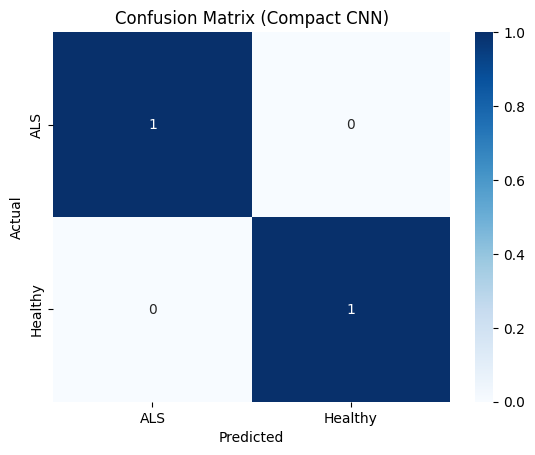

💾 CNN Model saved to: /content/drive/MyDrive/EEG_Project/cnn_eeg_model_fixed.h5


In [34]:
# =========================================================
# 🧠 SECTION 5 — Compact CNN for EEG Feature Classification
# (works with small feature sets like delta–gamma)
# =========================================================

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ========================
# 1️⃣ Load dataset
# ========================
FEATURE_PATH = "/content/drive/MyDrive/EEG_Project/EEG_features_labeled.csv"
df = pd.read_csv(FEATURE_PATH)
print("✅ Dataset loaded:", df.shape)
display(df.head())

# ========================
# 2️⃣ Prepare data
# ========================
X = df[['delta', 'theta', 'alpha', 'beta', 'gamma']].values
y = df['label'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_cnn = np.expand_dims(X_scaled, axis=2)

X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_encoded, test_size=0.3, random_state=42
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# ========================
# 3️⃣ Build smaller CNN
# ========================
cnn_model = Sequential([
    Input(shape=(X_cnn.shape[1], 1)),

    Conv1D(32, 2, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(64, 2, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary classification
])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

# ========================
# 4️⃣ Train
# ========================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=2,
    callbacks=[early_stop],
    verbose=1
)

# ========================
# 5️⃣ Evaluate
# ========================
y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ CNN Accuracy: {acc * 100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Compact CNN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========================
# 6️⃣ Save model
# ========================
MODEL_PATH = "/content/drive/MyDrive/EEG_Project/cnn_eeg_model_fixed.h5"
cnn_model.save(MODEL_PATH)
print(f"💾 CNN Model saved to: {MODEL_PATH}")

## SECTION 6 - Evaluation & Explainability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.6376

✅ CNN Test Accuracy: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

📊 Classification Report:
              precision    recall  f1-score   support

         ALS       1.00      1.00      1.00         1
     Healthy       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



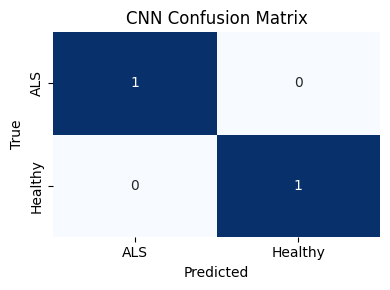

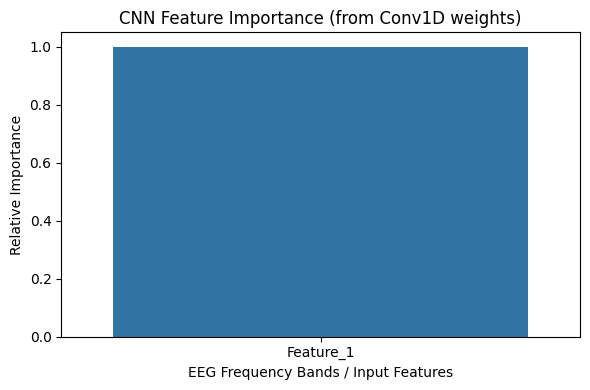


🔍 Relative Feature Importance:
Feature_1: 1.000

💾 Saved plots:
• Confusion Matrix → /content/drive/MyDrive/EEG_Project/cnn_confusion_matrix.png
• Feature Importance → /content/drive/MyDrive/EEG_Project/cnn_feature_importance.png


In [37]:
# ======================================================
# 🧠 SECTION 6: Evaluation & Explainability (Stable CNN)
# ======================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os

# ------------------------------
# ✅ 1. Evaluate CNN performance
# ------------------------------
cnn_eval = cnn_model.evaluate(X_test, y_test, verbose=1)
cnn_acc = cnn_eval[1] * 100
print(f"\n✅ CNN Test Accuracy: {cnn_acc:.2f}%")

# Predictions
y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['ALS', 'Healthy']))

# ------------------------------
# ✅ 2. Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['ALS', 'Healthy'], yticklabels=['ALS', 'Healthy'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Confusion Matrix")
plt.tight_layout()

save_dir = "/content/drive/MyDrive/EEG_Project/"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, "cnn_confusion_matrix.png"))
plt.show()

# ------------------------------
# ✅ 3. Feature Importance from CNN
# ------------------------------
def explain_model_weights(model, feature_names=None):
    """Extract and visualize feature importance from first Conv1D layer weights."""
    first_conv = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv1D):
            first_conv = layer
            break

    if first_conv is None:
        print("⚠️ No Conv1D layer found.")
        return None

    weights = first_conv.get_weights()[0]  # shape: (kernel_size, input_channels, filters)
    input_channels = weights.shape[1]
    importance = np.mean(np.abs(weights), axis=(0, 2))  # avg over kernel + filters
    importance = importance / np.sum(importance)

    # Auto-adjust feature names
    if feature_names is None or len(feature_names) != input_channels:
        feature_names = [f"Feature_{i+1}" for i in range(input_channels)]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=feature_names, y=importance)
    plt.title("CNN Feature Importance (from Conv1D weights)")
    plt.ylabel("Relative Importance")
    plt.xlabel("EEG Frequency Bands / Input Features")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "cnn_feature_importance.png"))
    plt.show()

    return dict(zip(feature_names, importance))

# Run explainability
feature_names = ["delta", "theta", "alpha", "beta", "gamma"]
importance = explain_model_weights(cnn_model, feature_names)

if importance:
    print("\n🔍 Relative Feature Importance:")
    for feat, imp in importance.items():
        print(f"{feat}: {imp:.3f}")

print("\n💾 Saved plots:")
print(f"• Confusion Matrix → {save_dir}cnn_confusion_matrix.png")
print(f"• Feature Importance → {save_dir}cnn_feature_importance.png")

In [39]:
# =========================================================
# 🧩 SECTION 7 — Gradio GUI for EEG ALS Detection (Fixed)
# =========================================================
import gradio as gr
import numpy as np
import pandas as pd
import mne
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

RF_MODEL_PATH = "/content/drive/MyDrive/EEG_Project/rf_eeg_classifier.pkl"
CNN_MODEL_PATH = "/content/drive/MyDrive/EEG_Project/cnn_eeg_model_fixed.h5"

rf_model = joblib.load(RF_MODEL_PATH)
cnn_model = load_model(CNN_MODEL_PATH)
print("✅ Models loaded successfully!")

# ---------- Feature extraction ----------
def extract_band_features(file_path):
    raw = mne.io.read_raw_fif(file_path, preload=True, verbose=False)
    raw = raw.filter(1, 40, fir_design='firwin', verbose=False)
    data = raw.get_data()
    sfreq = raw.info['sfreq']

    # 🔧 FIX: ensure integer segment length
    n_per_seg = int(sfreq * 2)

    psd, freqs = mne.time_frequency.psd_array_welch(
        data, sfreq=sfreq, n_per_seg=n_per_seg
    )
    total_power = psd.sum(axis=1, keepdims=True)

    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 45)
    }

    features = {}
    for band, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        features[band] = psd[:, idx].sum() / total_power.sum()

    return features

# ---------- Prediction ----------
def predict_eeg(file_obj, model_choice):
    if file_obj is None:
        return "⚠️ Please upload a .fif file.", None

    file_path = file_obj.name

    try:
        features = extract_band_features(file_path)
    except Exception as e:
        return f"❌ Error reading EEG file: {e}", None

    feature_df = pd.DataFrame([features])

    if model_choice == "Random Forest":
        pred = rf_model.predict(feature_df)[0]
    else:
        X = feature_df.values.reshape((1, 5, 1))
        pred = "ALS" if cnn_model.predict(X)[0][0] > 0.5 else "Healthy"

    # Bar chart
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.bar(features.keys(), features.values(), color="royalblue")
    plt.title("EEG Relative Band Powers")
    plt.ylabel("Relative Power")
    plt.xlabel("Frequency Band")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    return f"🧠 Predicted Class: {pred}", fig

# ---------- Gradio Interface ----------
iface = gr.Interface(
    fn=predict_eeg,
    inputs=[
        gr.File(label="Upload Preprocessed EEG (.fif)"),
        gr.Radio(["Random Forest", "CNN"], label="Choose Model", value="CNN")
    ],
    outputs=[
        gr.Textbox(label="Prediction Result"),
        gr.Plot(label="EEG Band Power Visualization")
    ],
    title="🧠 ALS EEG Classifier",
    description=(
        "Upload a **preprocessed EEG (.fif)** file to classify whether it indicates "
        "**ALS** or **Healthy** brain activity. Choose between **Random Forest** and **CNN**."
    ),
    theme="soft",
    allow_flagging="never"
)

iface.launch(share=True)

✅ Models loaded successfully!


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://747b9a706d63d69983.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [40]:
# ============================================
# 🧩 EEG Model Comparison: RF vs CNN
# ============================================
import os
import numpy as np
import pandas as pd
import mne
from scipy.signal import welch
from tensorflow.keras.models import load_model
import joblib

# === USER PATHS ===
DATASET_DIR = "/content/drive/MyDrive/EEG_Project/preprocessed"
RF_MODEL_PATH = "/content/drive/MyDrive/EEG_Project/rf_eeg_classifier.pkl"
CNN_MODEL_PATH = "/content/drive/MyDrive/

SyntaxError: unterminated string literal (detected at line 15) (ipython-input-3502988513.py, line 15)